# Import Packages

In [192]:
# Data and Maths
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import curve_fit

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import folium

# Bayesian Stuff
import pymc as pm
import arviz as az
from scipy.special import expit as logistic

# For geocoding
from geopy.geocoders import Nominatim # For folium maps to return centering coordinates
import osmnx as ox # To return the geometry of a target region or city
import ssl # For the certificates to make the osmnx work
ssl._create_default_https_context = ssl._create_unverified_context

import requests
from requests import get

import os
os.environ['USE_PYGEOS'] = '0'

# Load Data

### LSOA Data

#### Convenience Functions

In [2]:
# mask is a way of filtering a dataframe in a chained way
def mask(df, key, value):
    return df[df[key] == value]

pd.DataFrame.mask = mask

# apply_dtypes converts select columns from str to float values
def apply_dtypes(first, last):
    dtypes = {i: str for i in range(first)}  # first 'first' columns as strings
    dtypes.update({i: float for i in range(first, last)}) # 'last' columns is currently hard coded. Float is needed for NaNs
    return dtypes

#### LSOA Lookup Data
This dataset links the LSOA11CD, LSOA21CD and LAD22CD.

In [4]:
lsoa_lookup = pd.read_csv('../data/spatial_data/lsoa_data/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
lsoa_lookup.head()

LSOA11CD                   LSOA11NM   LSOA21CD                   LSOA21NM  \
0  E01000001        City of London 001A  E01000001        City of London 001A   
1  E01000002        City of London 001B  E01000002        City of London 001B   
2  E01000003        City of London 001C  E01000003        City of London 001C   
3  E01000005        City of London 001E  E01000005        City of London 001E   
4  E01000006  Barking and Dagenham 016A  E01000006  Barking and Dagenham 016A   

  CHGIND    LAD22CD               LAD22NM LAD22NMW  ObjectId  
0      U  E09000001        City of London      NaN         1  
1      U  E09000001        City of London      NaN         2  
2      U  E09000001        City of London      NaN         3  
3      U  E09000001        City of London      NaN         4  
4      U  E09000002  Barking and Dagenham      NaN         5

#### LSOA Geospatial Data
This dataset includes the polygons for the boundaries of the LSOAs. 

I then merge this with the LSOA Lookup data to enable easier filtering based on Local Authority.

In [73]:
lsoa_geo = (
    gpd.read_file('../data/spatial_data/lsoa_data/Lower_Layer_Super_Output_Areas__December_2011__Boundaries_Full_Clipped__BFC__EW_V3.shp')
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on = 'LSOA11CD', how='outer')
    .set_index('LSOA11CD')
) 
lsoa_geo.head()

OBJECTID                   LSOA11NM   BNG_E   BNG_N     LONG_  \
LSOA11CD                                                                   
E01000001         1        City of London 001A  532123  181632 -0.097140   
E01000002         2        City of London 001B  532480  181715 -0.091970   
E01000003         3        City of London 001C  532239  182033 -0.095320   
E01000005         4        City of London 001E  533581  181283 -0.076270   
E01000006         5  Barking and Dagenham 016A  544994  184274  0.089317   

               LAT   Shape_Leng     Shape__Are   Shape__Len  \
LSOA11CD                                                      
E01000001  51.5182  2635.767993  129865.314354  2635.767993   
E01000002  51.5188  2707.881853  228419.634727  2707.881853   
E01000003  51.5217  1224.638192   59054.351929  1224.638192   
E01000005  51.5147  2275.805348  189577.710655  2275.805348   
E01000006  51.5387  1966.092607  146536.995750  1966.092607   

                                                    geometry  \
LSOA11CD                                                       
E01000001  POLYGON ((532151.537 181867.433, 532152.500 18...   
E01000002  POLYGON ((532634.497 181926.016, 532632.048 18...   
E01000003  POLYGON ((532153.703 182165.155, 532158.250 18...   
E01000005  POLYGON ((533619.062 181402.364, 533639.868 18...   
E01000006  POLYGON ((545126.852 184310.838, 545145.213 18...   

                        LAD22NM  
LSOA11CD                         
E01000001        City of London  
E01000002        City of London  
E01000003        City of London  
E01000005        City of London  
E01000006  Barking and Dagenham

#### Target Local Authority (LA)
This is used to reduce the volume of data that is manipulated.

In [5]:
LA = 'Bath and North East Somerset' # Target Local Authority

#### LSOA Household Data
This data contains the number of households in each LSOA.

In [568]:
house_lsoa = (
    pd.read_csv('../data/demographic_data/census_2021/LSOA_households.csv')
    .rename(columns={'Lower layer Super Output Areas Code':'LSOA21CD', 'Lower layer Super Output Areas':'LSOA21NM', 'Observation':'N_households'})
    .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LSOA21CD', 'LAD22NM']], on = 'LSOA21CD', how='outer')
    .loc[lambda x: x['LAD22NM'] == LA]
    .drop(columns=['LAD22NM', 'LSOA21NM'])
    .set_index('LSOA11CD')
)

# Drop duplicate rows
house_lsoa = house_lsoa[~house_lsoa.index.duplicated(keep='first')]

house_lsoa.head()

LSOA21CD  N_households
LSOA11CD                          
E01014370  E01014370          1009
E01014371  E01014371          1044
E01014372  E01014372          1043
E01014373  E01014373           659
E01014374  E01014374           666

#### LSOA Vehicle Historical Registration Data (All)

This data contains the number of total vehicles registered in each LSOA from 2009 to the present day (2022 Q3 at the time of writing).

In [569]:
v_lsoa = (pd.read_csv('../data/vehicle_data/df_VEH0125.csv', dtype = apply_dtypes(5, 57), na_values=['[c]', '[x]'])
        .mask('BodyType', 'Cars') #  Filter for Cars only
        .mask('Keepership', 'Private') #  Filter for Private vehicles only
        .mask('LicenceStatus', 'Licensed') # Filter for Licensed vehicles only
        .drop(columns = ['BodyType', 'Keepership', 'LicenceStatus', 'LSOA11NM']) # Drop Filtered columns (As all same value)
        .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
        .loc[lambda x: x['LAD22NM'] == LA] # Filter for target Local Authority (BNES)
        .drop(columns = ['LAD22NM'])
        .set_index('LSOA11CD')
)

# Drop duplicate rows
v_lsoa = v_lsoa[~v_lsoa.index.duplicated(keep='first')]

v_lsoa

2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  \
LSOA11CD                                                                   
E01014370    353.0    357.0    352.0    369.0    390.0    382.0    380.0   
E01014371    512.0    507.0    524.0    517.0    524.0    524.0    530.0   
E01014372    507.0    506.0    509.0    513.0    508.0    506.0    508.0   
E01014373    754.0    770.0    768.0    775.0    762.0    773.0    740.0   
E01014374    762.0    759.0    756.0    746.0    750.0    741.0    739.0   
...            ...      ...      ...      ...      ...      ...      ...   
E01014483    445.0    446.0    449.0    453.0    456.0    445.0    433.0   
E01014484    405.0    397.0    385.0    392.0    385.0    379.0    380.0   
E01033078   1018.0   1026.0   1040.0   1050.0   1037.0   1017.0    986.0   
E01033079    707.0    723.0    728.0    734.0    750.0    749.0    732.0   
E01033080    578.0    591.0    597.0    587.0    595.0    592.0    572.0   

           2020 Q4  2020 Q3  2020 Q2  ...  2012 Q1  2011 Q4  2011 Q3  2011 Q2  \
LSOA11CD                              ...                                       
E01014370    371.0    372.0    359.0  ...    390.0    397.0    391.0    393.0   
E01014371    523.0    512.0    503.0  ...    537.0    552.0    546.0    557.0   
E01014372    500.0    479.0    453.0  ...    548.0    553.0    556.0    552.0   
E01014373    749.0    759.0    734.0  ...    680.0    674.0    690.0    688.0   
E01014374    727.0    718.0    700.0  ...    632.0    627.0    632.0    637.0   
...            ...      ...      ...  ...      ...      ...      ...      ...   
E01014483    431.0    429.0    441.0  ...    431.0    445.0    458.0    444.0   
E01014484    370.0    367.0    357.0  ...    374.0    371.0    366.0    367.0   
E01033078   1015.0   1005.0   1013.0  ...   1021.0   1017.0   1007.0   1004.0   
E01033079    736.0    740.0    734.0  ...    738.0    743.0    743.0    733.0   
E01033080    585.0    573.0    588.0  ...    620.0    629.0    618.0    624.0   

           2011 Q1  2010 Q4  2010 Q3  2010 Q2  2010 Q1  2009 Q4  
LSOA11CD                                                         
E01014370    384.0    389.0    406.0    378.0    384.0    386.0  
E01014371    552.0    540.0    538.0    549.0    547.0    557.0  
E01014372    571.0    561.0    588.0    604.0    595.0    591.0  
E01014373    695.0    692.0    684.0    696.0    692.0    703.0  
E01014374    634.0    633.0    637.0    628.0    627.0    641.0  
...            ...      ...      ...      ...      ...      ...  
E01014483    433.0    438.0    450.0    451.0    449.0    440.0  
E01014484    370.0    361.0    363.0    358.0    361.0    363.0  
E01033078   1000.0    998.0    991.0    974.0    981.0    981.0  
E01033079    734.0    725.0    729.0    705.0    705.0    707.0  
E01033080    624.0    631.0    622.0    622.0    604.0    601.0  

[115 rows x 52 columns]

#### LSOA EV Historial Registration Data

In [570]:
ev_lsoa = (pd.read_csv('../data/vehicle_data/df_VEH0145.csv', dtype = apply_dtypes(4, 56), na_values=['[c]', '[x]'])
        .mask('Keepership', 'Private') #  Filter for Private vehicles only
        .drop(columns = ['Keepership', 'LSOA11NM']) # Drop Filtered columns (As all same value)
        .merge(lsoa_lookup.loc[:, ['LSOA11CD', 'LAD22NM']], on='LSOA11CD', how='outer')
        .loc[lambda x: x['LAD22NM'] == LA]
        .drop(columns = ['LAD22NM'])
        .set_index('LSOA11CD')
)

# Drop duplicate rows
ev_lsoa = ev_lsoa[~ev_lsoa.index.duplicated(keep='first')]

ev_lsoa.head()

Fuel  2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  \
LSOA11CD                                                                   
E01014370  Battery electric      8.0      7.0      8.0      8.0      6.0   
E01014371  Battery electric      5.0      5.0      5.0      NaN      NaN   
E01014372  Battery electric      5.0      5.0      5.0      NaN      5.0   
E01014373  Battery electric     12.0     11.0     11.0     11.0      9.0   
E01014374  Battery electric     17.0     18.0     18.0     15.0     15.0   

           2021 Q2  2021 Q1  2020 Q4  2020 Q3  ...  2014 Q1  2013 Q4  2013 Q3  \
LSOA11CD                                       ...                              
E01014370      NaN      NaN      NaN      NaN  ...      0.0      0.0      0.0   
E01014371      NaN      NaN      NaN      NaN  ...      0.0      0.0      0.0   
E01014372      5.0      5.0      6.0      5.0  ...      0.0      0.0      0.0   
E01014373      7.0      7.0      7.0      7.0  ...      0.0      0.0      0.0   
E01014374     10.0      8.0      5.0      5.0  ...      NaN      NaN      NaN   

           2013 Q2  2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                                  
E01014370      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 45 columns]

BEVs

In [571]:
bev_lsoa = (ev_lsoa
        .query("Fuel == 'Battery electric' or Fuel.isnull()") # Fill in missing rows
        .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)
bev_lsoa.head()

2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  \
LSOA11CD                                                                   
E01014370      8.0      7.0      8.0      8.0      6.0      NaN      NaN   
E01014371      5.0      5.0      5.0      NaN      NaN      NaN      NaN   
E01014372      5.0      5.0      5.0      NaN      5.0      5.0      5.0   
E01014373     12.0     11.0     11.0     11.0      9.0      7.0      7.0   
E01014374     17.0     18.0     18.0     15.0     15.0     10.0      8.0   

           2020 Q4  2020 Q3  2020 Q2  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014370      NaN      NaN      NaN  ...      0.0      0.0      0.0      0.0   
E01014371      NaN      NaN      0.0  ...      0.0      0.0      0.0      0.0   
E01014372      6.0      5.0      NaN  ...      0.0      0.0      0.0      0.0   
E01014373      7.0      7.0      6.0  ...      0.0      0.0      0.0      0.0   
E01014374      5.0      5.0      5.0  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014370      0.0      0.0      0.0      0.0      0.0      0.0  
E01014371      0.0      0.0      0.0      0.0      0.0      0.0  
E01014372      0.0      0.0      0.0      0.0      0.0      0.0  
E01014373      0.0      0.0      0.0      0.0      0.0      0.0  
E01014374      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 44 columns]

PHEVs

In [572]:
phev_lsoa = (ev_lsoa
        .query("Fuel == 'Plug-in hybrid electric (petrol)' or Fuel.isnull()") # Fill in missing rows
        .drop(columns = ['Fuel']) # Drop Fuel column as all identical
)
phev_lsoa.head()

2022 Q3  2022 Q2  2022 Q1  2021 Q4  2021 Q3  2021 Q2  2021 Q1  \
LSOA11CD                                                                   
E01014431      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014435      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014458      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014461      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
E01014462      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

           2020 Q4  2020 Q3  2020 Q2  ...  2014 Q1  2013 Q4  2013 Q3  2013 Q2  \
LSOA11CD                              ...                                       
E01014431      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
E01014435      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
E01014458      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
E01014461      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
E01014462      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   

           2013 Q1  2012 Q4  2012 Q3  2012 Q2  2012 Q1  2011 Q4  
LSOA11CD                                                         
E01014431      NaN      NaN      NaN      NaN      NaN      NaN  
E01014435      NaN      NaN      NaN      NaN      NaN      NaN  
E01014458      NaN      NaN      NaN      NaN      NaN      NaN  
E01014461      NaN      NaN      NaN      NaN      NaN      NaN  
E01014462      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 44 columns]

### Distribution Substation (DS) Data

#### DS Customer Data
The important sets of information in this dataset are: 
- The number of customers (assumed to be number of households)
- The location of the distribution substation
- The max day demand of the distribution substation

In [13]:
ds = (pd.read_csv('../data/network_data/distribution_substations.csv')
    .drop(columns = ['Transformer Headroom', 'LCT Count Total', 'Energy Storage', 'Heat Pumps', 
                    'EV Chargers', 'Total LCT Capacity', 'Total Generation Capacity', 'Solar', 
                    'Wind', 'Bio Fuels', 'Water Generation', 'Waste Generation',
                    'Storage Generation', 'Fossil Fuels', 'Other Generation']
    )
    .replace('Hidden', np.nan)
    .astype({'Customers':'float64', 'Substation Number':'Int64'})
    .astype({'Substation Number': str})
)
ds.head()

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_84665/3914828000.py:1: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  ds = (pd.read_csv('../data/network_data/distribution_substations.csv')


index License Area  Grid Supply Point Number Grid Supply Point Name  \
0      0   South West                    306004          Abham  S.G.P.   
1      1   South West                    306004          Abham  S.G.P.   
2      2   South West                    306004          Abham  S.G.P.   
3      4   South West                    306004          Abham  S.G.P.   
4      5   South West                    406003       Landulph  S.G.P.   

   Bulk Supply Point Number Bulk Supply Point Name     Primary Name  \
0                    330006           Plympton Bsp    Linketty Lane   
1                    330003           Plymouth Bsp  Plymstock South   
2                    330003           Plymouth Bsp  Plymstock South   
3                    330006           Plympton Bsp    Linketty Lane   
4                    330001         Ernesettle Bsp         Southway   

   Primary Number    HV Feeder Substation Type       Substation Name  \
0          330029  330029/0016        Grd Mtd     Burniston Close 47   
1          330037  330037/0017        Grd Mtd          Furland Close   
2          330037  330037/0018        Grd Mtd           Staddon Park   
3          330029  330029/0016        Grd Mtd        St Maurice Road   
4          330023  330023/0046        Grd Mtd   Birch Valley Plastic   

  Substation Number  Grid Reference  LONGITUDE   LATITUDE  Day Max Demand  \
0            331299  SX553570552680  -4.035800  50.379400           189.0   
1            332445  SX504350522380  -4.103733  50.350925            88.0   
2            331216  SX513550525160  -4.090900  50.353700           184.0   
3            331196  SX548280554220  -4.043300  50.380700           286.0   
4            333252  SX513960603110  -4.093400  50.423700           746.0   

   Night Max Demand  Substation Rating  Customers  
0              78.0              500.0      115.0  
1              46.0             1000.0       59.0  
2             106.0              500.0      149.0  
3             121.0              500.0      178.0  
4             453.0             1000.0       27.0

#### DS Geospatial Data
This dataset is useful as it contains the approximate polygons for the boundaries of the distribution substation areas. Here, it is merged with the DS customer data. 

This is only included for choropleth plotting purposes. 

In [14]:
ds_geo = (
    gpd.read_file('../data/network_data/dist_swest_march2023.gpkg')
    .rename(columns={'NR':'Substation Number'})
    .dissolve('Substation Number').reset_index()
    .merge(ds, how='left', on ='Substation Number')
    .rename(columns={'Substation Name':'Name'})
    .fillna(value={'Discount':'Unknown'}) # For the "key_on" part of the choropleth map
    .to_crs('EPSG:4326')
)

ds_geo.head()

Substation Number                                           geometry   NRID  \
0            110001  MULTIPOLYGON (((-2.58570 51.47167, -2.58578 51...  33447   
1            110002  MULTIPOLYGON (((-2.59002 51.47053, -2.59028 51...  33449   
2            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
3            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
4            110004  MULTIPOLYGON (((-2.58898 51.47610, -2.58895 51...  33453   

   NR_TYPE_ID                NAME  PRIM_NRID     PRIM_NRID_NAME  BSP_NRID  \
0          19  Chesterfield Rd Id      15039  St Pauls Bsp 11kv       104   
1          19   Effingham Road Id      15039  St Pauls Bsp 11kv       104   
2          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
3          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
4          19         Kent Road P      15039  St Pauls Bsp 11kv       104   

        BSP_NRID_NAME  GSP_NRID  ...    HV Feeder  Substation Type  \
0  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
1  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
2  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
3  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    
4  St Pauls Bsp 132kv       130  ...  110804/0055         Grd Mtd    

                 Name  Grid Reference LONGITUDE  LATITUDE Day Max Demand  \
0  Chesterfield Rd Id  ST596270749730   -2.5827   51.4722          568.0   
1   Effingham Road Id  ST591950749860   -2.5889   51.4723          458.0   
2       Somerville Rd  ST590740753250   -2.5907   51.4753           10.0   
3       Somerville Rd  ST590740753250   -2.5907   51.4753            0.0   
4         Kent Road P  ST593560755280   -2.5867   51.4772          607.0   

  Night Max Demand  Substation Rating Customers  
0            343.0              750.0     367.0  
1            275.0              750.0     331.0  
2              4.0              250.0     254.0  
3              0.0              500.0       NaN  
4            320.0              750.0     276.0  

[5 rows x 29 columns]

### Target Local Authority (LA) Geometry
This is simply to filter the DS that are located within the target LA.

<Axes: >

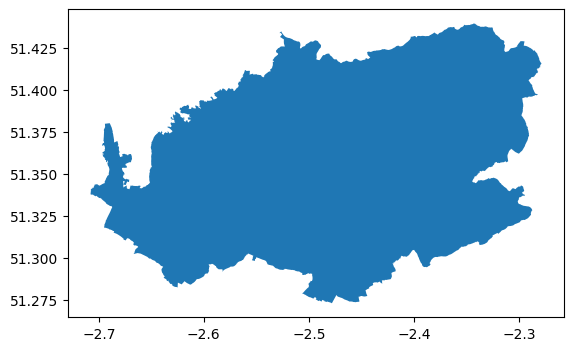

In [15]:
LA_geo = ox.geocoder.geocode_to_gdf(LA, which_result=1)
LA_geo.plot()

# Data Pre-processing

### Calculate Vehicle-to-Household Ratio
This ratio allows the estimation of the total number of vehicles that are within the DS supply area. 

This works on the assumption that the number of customers connected to a DS represent households and not every individual in the area.

Text(0.5, 0, 'vehicles_per_household')

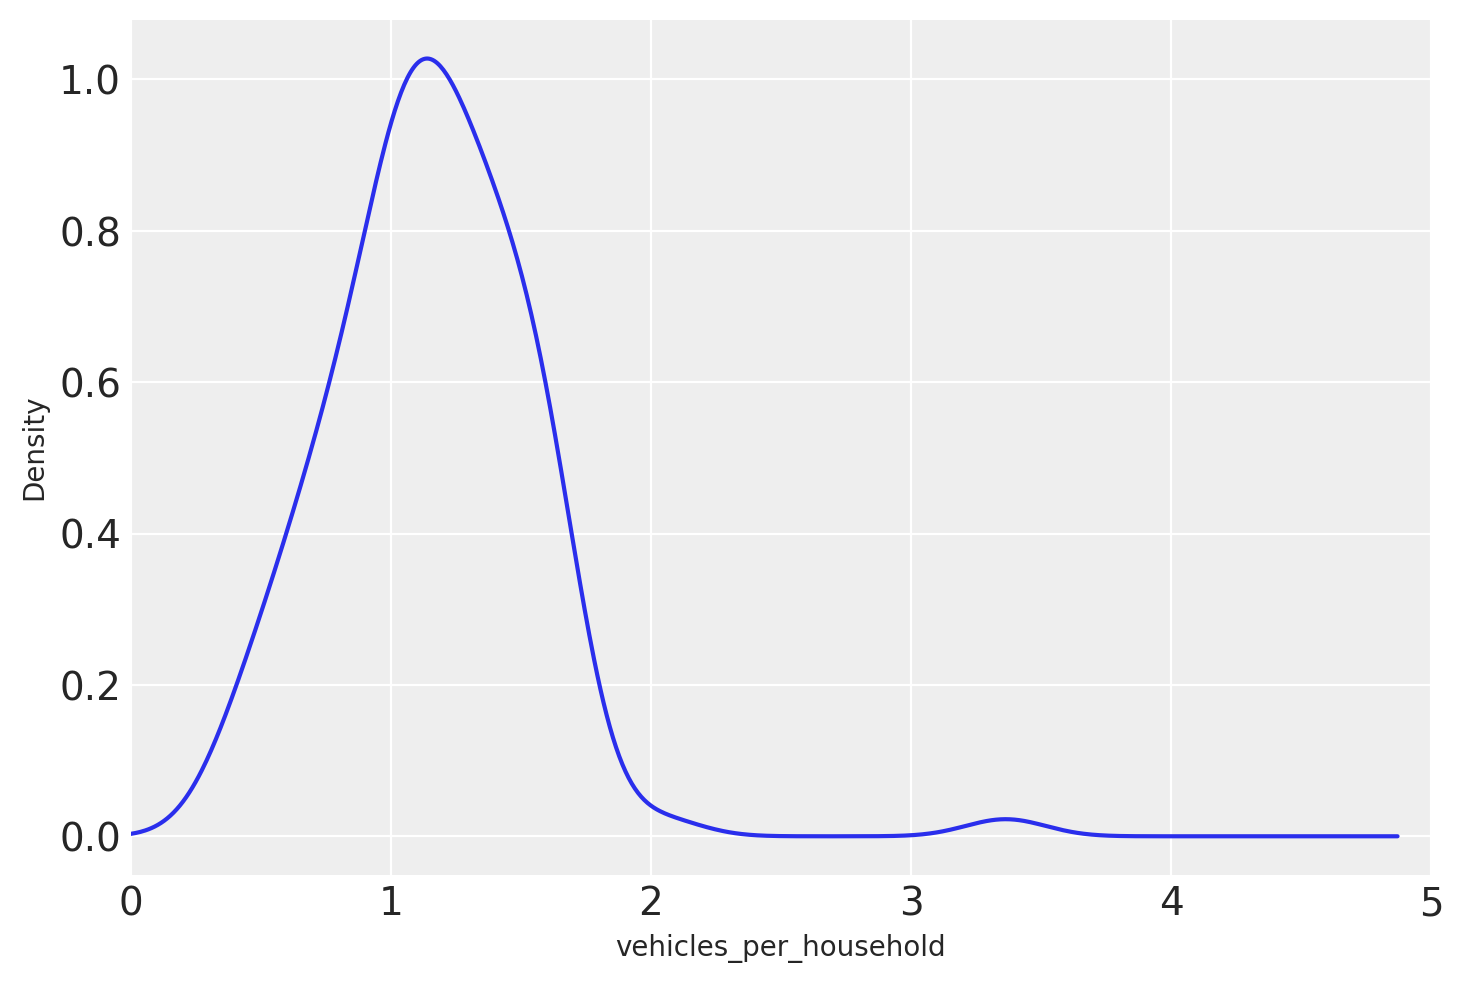

In [573]:
vehicles_per_household = v_lsoa.iloc[:, 0] / house_lsoa.N_households
ax = vehicles_per_household.plot(kind='density', xlim=(0, 5))
ax.set_xlabel('vehicles_per_household')

### Interpolate Missing Registration Data

Convenience functions for converting string dates to numerical dates and date ranges

In [35]:
# Find the earliest date in the data (t0) and convert from a string format (e.g. 2022 Q3) to a numerical format
def calculate_t0(data):
    year = int(data.head(1).index[0][:4])
    quarter = data.head(1).index[0][-2:]
    if quarter == 'Q1':
        t0 = year + 0
    elif quarter == 'Q2':
        t0 = year + 0.25
    elif quarter == 'Q3':
        t0 = year + 0.5
    elif quarter == 'Q4':
        t0 = year + 0.75
    
    return t0

# Find the latest date in the data (t0) and convert from a string format (e.g. 2022 Q3) to a numerical format
def calculate_t_present(data):
    year = int(data.tail(1).index[0][:4])
    quarter = data.tail(1).index[0][-2:]
    if quarter == 'Q1':
        t_present = year + 0
    elif quarter == 'Q2':
        t_present = year + 0.25
    elif quarter == 'Q3':
        t_present = year + 0.5
    elif quarter == 'Q4':
        t_present = year + 0.75
        
    return t_present

# Returns a numerical date range between two dates (in numerical form) at a specified sample rate (in this case the sample rate is 4 (quarterly))
def calculate_date_range(start, end, sample_rate):
    return np.linspace(start, end, int((end-start)*sample_rate) + 1)

The interpolation function

In [54]:
def interpolate_registration(data, sample_rate):
    def interpolate_col(col):
        dates = calculate_date_range(calculate_t0(col), calculate_t_present(col), sample_rate)
        mask = ~col.isna().values
        if mask.any():
            xp = dates[mask]
            fp = col[mask]
            x = dates
            interpolated = np.round(np.interp(x, xp, fp))
            return pd.Series(data=interpolated, index=col.index)
        else:
            return pd.Series(data=np.nan, index=col.index)
    
    interpolated_df = data.apply(interpolate_col, axis=0)
    
    return interpolated_df

In [37]:
sample_rate = 4 # Quarterly

In [58]:
bev_lsoa_i = interpolate_registration(bev_lsoa.T.iloc[::-1], sample_rate)
phev_lsoa_i = interpolate_registration(phev_lsoa.T.iloc[::-1], sample_rate)

### Compute Historical BEV and PHEV penetration

In [123]:
bev_pen_lsoa = bev_lsoa_i.div(v_lsoa.T.iloc[::-1]).fillna(0)
phev_pen_lsoa = phev_lsoa_i.div(v_lsoa.T.iloc[::-1]).fillna(0)

### Calculate specific locations of DS from Latitude and Longitude Data

In [61]:
ds_locations = gpd.GeoSeries(gpd.points_from_xy(ds_geo.LONGITUDE, ds_geo.LATITUDE, crs="EPSG:4326"))
ds_locations

0        POINT (-2.58270 51.47220)
1        POINT (-2.58890 51.47230)
2        POINT (-2.59070 51.47530)
3        POINT (-2.59070 51.47530)
4        POINT (-2.58670 51.47720)
                   ...            
53659    POINT (-2.29490 51.43120)
53660    POINT (-2.31250 51.42950)
53661    POINT (-2.45198 51.47729)
53662    POINT (-2.59070 51.58920)
53663    POINT (-2.50920 51.56140)
Length: 53664, dtype: geometry

In [62]:
ds_geo['Location'] = ds_locations
ds_geo.head()

Substation Number                                           geometry   NRID  \
0            110001  MULTIPOLYGON (((-2.58570 51.47167, -2.58578 51...  33447   
1            110002  MULTIPOLYGON (((-2.59002 51.47053, -2.59028 51...  33449   
2            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
3            110003  POLYGON ((-2.59156 51.47416, -2.59154 51.47425...  33451   
4            110004  MULTIPOLYGON (((-2.58898 51.47610, -2.58895 51...  33453   

   NR_TYPE_ID                NAME  PRIM_NRID     PRIM_NRID_NAME  BSP_NRID  \
0          19  Chesterfield Rd Id      15039  St Pauls Bsp 11kv       104   
1          19   Effingham Road Id      15039  St Pauls Bsp 11kv       104   
2          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
3          19       Somerville Rd      15039  St Pauls Bsp 11kv       104   
4          19         Kent Road P      15039  St Pauls Bsp 11kv       104   

        BSP_NRID_NAME  GSP_NRID  ... Substation Type                Name  \
0  St Pauls Bsp 132kv       130  ...        Grd Mtd   Chesterfield Rd Id   
1  St Pauls Bsp 132kv       130  ...        Grd Mtd    Effingham Road Id   
2  St Pauls Bsp 132kv       130  ...        Grd Mtd        Somerville Rd   
3  St Pauls Bsp 132kv       130  ...        Grd Mtd        Somerville Rd   
4  St Pauls Bsp 132kv       130  ...        Grd Mtd          Kent Road P   

   Grid Reference  LONGITUDE LATITUDE  Day Max Demand Night Max Demand  \
0  ST596270749730    -2.5827  51.4722           568.0            343.0   
1  ST591950749860    -2.5889  51.4723           458.0            275.0   
2  ST590740753250    -2.5907  51.4753            10.0              4.0   
3  ST590740753250    -2.5907  51.4753             0.0              0.0   
4  ST593560755280    -2.5867  51.4772           607.0            320.0   

  Substation Rating  Customers                   Location  
0             750.0      367.0  POINT (-2.58270 51.47220)  
1             750.0      331.0  POINT (-2.58890 51.47230)  
2             250.0      254.0  POINT (-2.59070 51.47530)  
3             500.0        NaN  POINT (-2.59070 51.47530)  
4             750.0      276.0  POINT (-2.58670 51.47720)  

[5 rows x 30 columns]

### Filter DS based on target LA

In [63]:
ds_LA = ds_geo.loc[ds_geo.Location.within(LA_geo.geometry.values[0])]
ds_LA.head()

Substation Number                                           geometry  \
37             110055  POLYGON ((-2.46167 51.39973, -2.46174 51.39976...   
39             110060  POLYGON ((-2.49497 51.40702, -2.49581 51.40727...   
44             110066  POLYGON ((-2.49769 51.40349, -2.49779 51.40351...   
107            110165  POLYGON ((-2.51360 51.41669, -2.51393 51.41716...   
123            110182  POLYGON ((-2.46675 51.40341, -2.46675 51.40341...   

      NRID  NR_TYPE_ID               NAME  PRIM_NRID PRIM_NRID_NAME  BSP_NRID  \
37   33528          19        Saltford Od      15042  Keynsham East       119   
39   33532          19  Keelings       Ss      15042  Keynsham East       119   
44   33542          19   Burnett Rd     K      15042  Keynsham East       119   
107  33683          19  Stockwood Vale Od      15049  Keynsham West    128239   
123  33715          19   Grange Road    K      15042  Keynsham East       119   

          BSP_NRID_NAME  GSP_NRID  ... Substation Type  \
37   Radstock Bsp 132kv    136677  ...        Grd Mtd    
39   Radstock Bsp 132kv    136677  ...        Grd Mtd    
44   Radstock Bsp 132kv    136677  ...        Grd Mtd    
107    Feeder Road 33kv       130  ...        Grd Mtd    
123  Radstock Bsp 132kv    136677  ...        Grd Mtd    

                         Name  Grid Reference  LONGITUDE   LATITUDE  \
37                Saltford Od  ST682140670940   -2.45840  51.401900   
39          Keelings       Ss  ST658270679910   -2.49280  51.409800   
44           Burnett Rd     K  ST658460673840   -2.49242  51.404389   
107         Stockwood Vale Od  ST644800689440   -2.51220  51.418300   
123  Grange Road  K  Saltford  ST677120673570   -2.46560  51.404300   

     Day Max Demand Night Max Demand Substation Rating  Customers  \
37            339.0            228.0             500.0      129.0   
39            204.0             90.0             315.0      114.0   
44            157.0             70.0             300.0       95.0   
107           102.0             49.0             500.0       47.0   
123           104.0             50.0             315.0       54.0   

                      Location  
37   POINT (-2.45840 51.40190)  
39   POINT (-2.49280 51.40980)  
44   POINT (-2.49242 51.40439)  
107  POINT (-2.51220 51.41830)  
123  POINT (-2.46560 51.40430)  

[5 rows x 30 columns]

### Filter LSOAs based on target LA

This is simply because I need to convert the ESPG from 27700 to 4326. 

This takes a ridiculously long time when try to convert all of the geometries of the LSOAs in the UK. 

Therefore, to speed things up, I need to filter the LSOAs first and then apply the coordinate transformation

In [75]:
lsoa_LA = lsoa_geo.loc[lambda x: x['LAD22NM'] == LA].to_crs('EPSG:4326') # Filter for LA and change CRS
lsoa_LA

OBJECTID                           LSOA11NM   BNG_E   BNG_N  \
LSOA11CD                                                                 
E01014370     13973  Bath and North East Somerset 007A  375084  164994   
E01014371     13974  Bath and North East Somerset 007B  375328  164841   
E01014372     13975  Bath and North East Somerset 007C  374832  165378   
E01014373     13976  Bath and North East Somerset 010A  377791  167691   
E01014374     13977  Bath and North East Somerset 010B  378059  166769   
...             ...                                ...     ...     ...   
E01014483     14083  Bath and North East Somerset 012E  375520  164200   
E01014484     14084  Bath and North East Somerset 012F  374167  164552   
E01033078     32407  Bath and North East Somerset 010G  377724  159696   
E01033079     32408  Bath and North East Somerset 010H  374437  157903   
E01033080     32409  Bath and North East Somerset 009E  374154  165257   

             LONG_      LAT    Shape_Leng    Shape__Are    Shape__Len  \
LSOA11CD                                                                
E01014370 -2.35941  51.3834   4168.323516  3.770303e+05   4168.323516   
E01014371 -2.35590  51.3821   4146.079795  4.094906e+05   4146.079795   
E01014372 -2.36306  51.3869   2870.144109  1.668015e+05   2870.144109   
E01014373 -2.32068  51.4078   6720.118267  1.059979e+06   6720.118267   
E01014374 -2.31677  51.3995  19927.251976  5.002127e+06  19927.251976   
...            ...      ...           ...           ...           ...   
E01014483 -2.35309  51.3763   4349.137751  4.374178e+05   4349.137751   
E01014484 -2.37256  51.3794   3708.699962  4.154735e+05   3708.699962   
E01033078 -2.32114  51.3359  36491.970744  1.551255e+07  36491.970744   
E01033079 -2.36820  51.3196  29356.931964  1.966725e+07  29356.931964   
E01033080 -2.37280  51.3858   3955.277903  5.243228e+05   3955.277903   

                                                    geometry  \
LSOA11CD                                                       
E01014370  POLYGON ((-2.35647 51.38920, -2.35618 51.38913...   
E01014371  POLYGON ((-2.35166 51.38534, -2.35158 51.38530...   
E01014372  POLYGON ((-2.35597 51.38950, -2.35587 51.38942...   
E01014373  POLYGON ((-2.32115 51.41364, -2.32114 51.41364...   
E01014374  POLYGON ((-2.30592 51.40806, -2.30591 51.40806...   
...                                                      ...   
E01014483  POLYGON ((-2.34970 51.37967, -2.34964 51.37960...   
E01014484  POLYGON ((-2.36965 51.38136, -2.36952 51.38096...   
E01033078  POLYGON ((-2.32760 51.36257, -2.32743 51.36222...   
E01033079  POLYGON ((-2.34124 51.34348, -2.34125 51.34339...   
E01033080  POLYGON ((-2.36727 51.38976, -2.36724 51.38975...   

                                LAD22NM  
LSOA11CD                                 
E01014370  Bath and North East Somerset  
E01014371  Bath and North East Somerset  
E01014372  Bath and North East Somerset  
E01014373  Bath and North East Somerset  
E01014374  Bath and North East Somerset  
...                                 ...  
E01014483  Bath and North East Somerset  
E01014484  Bath and North East Somerset  
E01033078  Bath and North East Somerset  
E01033079  Bath and North East Somerset  
E01033080  Bath and North East Somerset  

[118 rows x 11 columns]

In [78]:
lsoa_LA.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 118 entries, E01014370 to E01033080
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    118 non-null    int64   
 1   LSOA11NM    118 non-null    object  
 2   BNG_E       118 non-null    int64   
 3   BNG_N       118 non-null    int64   
 4   LONG_       118 non-null    float64 
 5   LAT         118 non-null    float64 
 6   Shape_Leng  118 non-null    float64 
 7   Shape__Are  118 non-null    float64 
 8   Shape__Len  118 non-null    float64 
 9   geometry    118 non-null    geometry
 10  LAD22NM     118 non-null    object  
dtypes: float64(5), geometry(1), int64(3), object(2)
memory usage: 15.1+ KB


# Link DS to LSOA

### Target DS

In [160]:
DS_number = '110055' # '110055'

### Find Parent LSOA

In [161]:
parent_lsoa = lsoa_LA.loc[lsoa_LA.geometry.contains(ds_LA[ds_LA['Substation Number'] == DS_number].iloc[0].Location)].index[0]
parent_lsoa

'E01014452'

### Return vehicle to household ratio for parent LSOA

In [162]:
vehicles_per_household.loc[parent_lsoa]

1.2844175491679273

### Estimate total number of vehicles within DS area

Number of DS Customers multiplied by the vehicle-to-household ratio

In [163]:
n_vehicle_est = ds_LA[ds_LA['Substation Number'] == DS_number].iloc[0].Customers * vehicles_per_household.loc[parent_lsoa]
n_vehicle_est

165.68986384266262

# Logistic Growth Model

## Generalised Logistic Growth

This is a much more flexible version of the basic logistic growth model used previously.

$$Y(t) = A + \frac{K - A}{\left(C + Qe^{-B\left(t - M\right)}\right)^{\frac{1}{v}}}$$

$A$ is the lower asymptote  
$K$ is the upper asumptote  
$B$ is the growth rate  
$v > 0$ affects which asymptote maxximum growth occurs     
$Q$ is related to the value of $Y(0)$   
$C$ typically takes the value of 1  
$M$ can be thought of as the starting time

### Time Horizon

In [164]:
horizon = 2030 # Forecast Horizon

### Functions

In [240]:
def generalised_logistic_growth(X, B, v, Q, M):
    t, data = X
    K = 1
    A = data[0]
    C = 1
    denominator = (C + Q*np.exp(-B * (t - M)))**(1/v)

    return A + ((K - A) / denominator)

def fit_generalised_logistic_curve(logistic_growth, data, t0, t_present, horizon, sample_rate, p0):
    T = np.arange(0, int(sample_rate * (t_present - t0)) + 1)
    parameters, covariance = curve_fit(logistic_growth, (T, data), data, p0, maxfev=5000)
    
    fit_B = parameters[0]
    fit_v = parameters[1]
    fit_Q = parameters[2]
    fit_M = parameters[3]

    F = np.arange(0, int(sample_rate * (horizon - t0)) + 1) # Historical + Future
    return generalised_logistic_growth((F, data), B=fit_B, v=fit_v, Q=fit_Q, M=fit_M)

def plot_generalised_logistic_projection(pen, pen_proj, dates, t0, t_present, sample_rate, title, region):
    plt.figure(figsize=(10,6))
    T = np.arange(0, int(sample_rate * (t_present - t0)) + 1) # Historical
    plt.plot(dates[:len(T)], pen, 'o', label='{} Data'.format(region))
    plt.plot(dates, pen_proj, '-', label='{} Fit'.format(region))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.show()

### Curve Fitting

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_84665/4176650248.py:6: RuntimeWarning: invalid value encountered in power
  denominator = (C + Q*np.exp(-B * (t - M)))**(1/v)


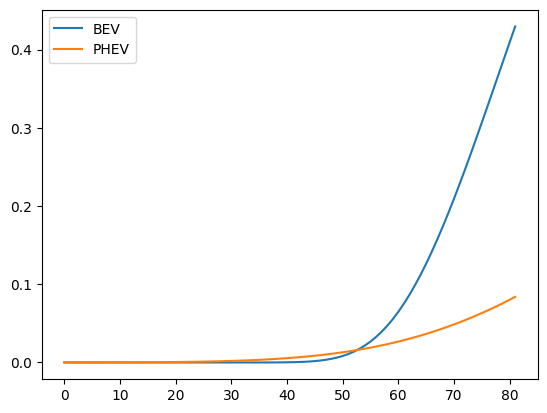

In [166]:
bev_pen_proj = fit_generalised_logistic_curve(
    logistic_growth=generalised_logistic_growth, 
    data=bev_pen_lsoa[parent_lsoa], 
    t0=calculate_t0(bev_pen_lsoa[parent_lsoa]), 
    t_present=calculate_t_present(bev_pen_lsoa[parent_lsoa]), 
    horizon=horizon, 
    sample_rate=sample_rate, 
    p0=[0, 1, 5, -5]
)

phev_pen_proj = fit_generalised_logistic_curve(
    logistic_growth=generalised_logistic_growth, 
    data=phev_pen_lsoa[parent_lsoa], 
    t0=calculate_t0(phev_pen_lsoa[parent_lsoa]), 
    t_present=calculate_t_present(phev_pen_lsoa[parent_lsoa]), 
    horizon=horizon, 
    sample_rate=sample_rate, 
    p0=[0, 1, 5, -5]
)

plt.plot(bev_pen_proj, label = "BEV")
plt.plot(phev_pen_proj, label = "PHEV")
plt.legend()

### Plot Fit to Data

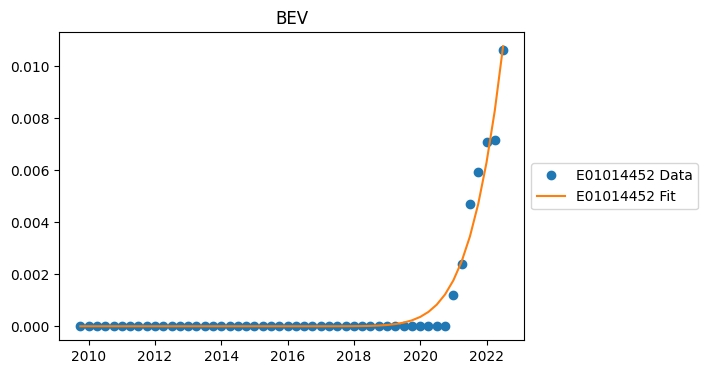

In [167]:
dates = calculate_date_range(calculate_t0(bev_pen_lsoa), horizon, sample_rate)
plt.figure(figsize=(6,4))
T = np.arange(0, len(bev_pen_lsoa))
plt.plot(dates[:len(T)], bev_pen_lsoa[parent_lsoa], 'o', label='{} Data'.format(parent_lsoa))
plt.plot(dates[:len(T)], bev_pen_proj[:len(T)], '-', label='{} Fit'.format(parent_lsoa))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('BEV')
plt.show()

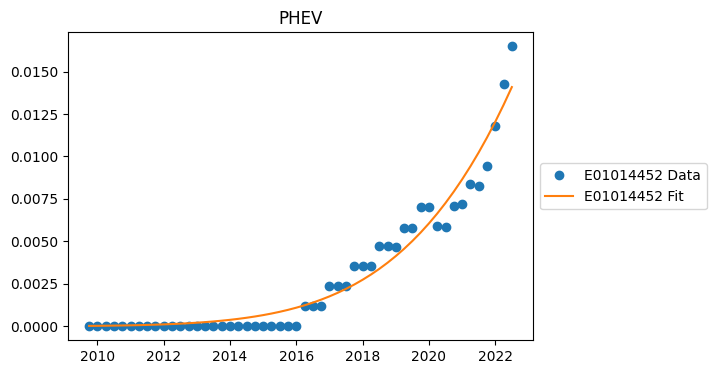

In [168]:
dates = calculate_date_range(calculate_t0(phev_pen_lsoa), horizon, sample_rate)
plt.figure(figsize=(6,4))
T = np.arange(0, len(phev_pen_lsoa))
plt.plot(dates[:len(T)], phev_pen_lsoa[parent_lsoa], 'o', label='{} Data'.format(parent_lsoa))
plt.plot(dates[:len(T)], phev_pen_proj[:len(T)], '-', label='{} Fit'.format(parent_lsoa))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('PHEV')
plt.show()

### Plot Projection to Time Horizon

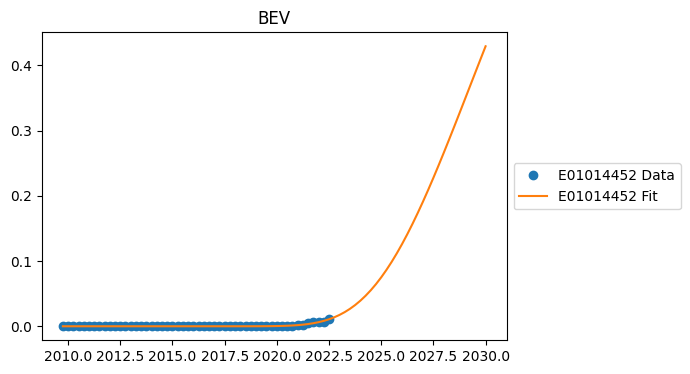

In [169]:
plot_generalised_logistic_projection(
    bev_pen_lsoa[parent_lsoa], 
    bev_pen_proj, 
    dates=dates, 
    t0=calculate_t0(bev_pen_lsoa), 
    t_present=calculate_t_present(bev_pen_lsoa), 
    sample_rate=sample_rate, 
    title='BEV', 
    region=parent_lsoa
)

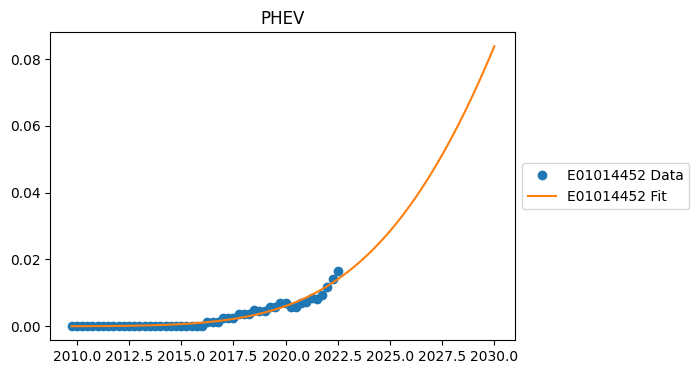

In [170]:
plot_generalised_logistic_projection(
    phev_pen_lsoa[parent_lsoa], 
    phev_pen_proj, 
    dates=dates, 
    t0=calculate_t0(phev_pen_lsoa), 
    t_present=calculate_t_present(phev_pen_lsoa), 
    sample_rate=sample_rate, 
    title='PHEV', 
    region=parent_lsoa
)

### Return forecast for a given target year

In [187]:
target_year = 2030

bev_pen_proj_s = pd.Series(data=bev_pen_proj, index=dates) # Make into a series for easy indexing
phev_pen_proj_s = pd.Series(data=phev_pen_proj, index=dates)

pred_n_bev = round(n_vehicle_est * bev_pen_proj_s.loc[target_year])
pred_n_phev = round(n_vehicle_est * phev_pen_proj_s.loc[target_year])

pred_n_bev

71

# Residential Charger Estimation

At the moment this is very basic just got keep the numbers flowing.

In [188]:
bev_res_charger_access = 0.8 # assume 80% of BEVs have access to a residential charger
phev_res_charger_access = 0.6 # assume 60% of PHEVs have access to a residential charger

In [189]:
# Predicted number of active residential chargers based on the current number of vehicles and the projected BEV penetration
pred_num_bev_chargers = round(pred_n_bev * bev_res_charger_access)
pred_num_bev_chargers

57

In [190]:
pred_num_phev_chargers = round(pred_n_phev * phev_res_charger_access)
pred_num_phev_chargers

8

# Bayesian Demand Model

### Plotting Setup

In [193]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

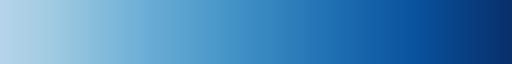

In [194]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.colormaps['Blues']
new_cmap = truncate_colormap(cmap, 0.3, 1)
new_cmap

In [195]:
NUM_COLORS = 20
cm = plt.get_cmap('Paired')
colors = [new_cmap(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

### Import Electric Nation Data

In [197]:
df = pd.read_csv('../data/hourly_data.csv')
df_agg = df.groupby(['PIV', 'Time'], as_index=False)[['Charging', 'Not_charging', 'N_active']].agg('sum')
df_agg

PIV  Time  Charging  Not_charging  N_active
0    BEV     0      5950         53342     59292
1    BEV     1      4243         54949     59192
2    BEV     2      2740         56355     59095
3    BEV     3      1756         57287     59043
4    BEV     4      1134         57856     58990
5    BEV     5       730         58232     58962
6    BEV     6       467         58468     58935
7    BEV     7       454         58475     58929
8    BEV     8       602         58333     58935
9    BEV     9       972         57988     58960
10   BEV    10      1389         57603     58992
11   BEV    11      1480         57539     59019
12   BEV    12      1621         57432     59053
13   BEV    13      1811         57274     59085
14   BEV    14      1933         57166     59099
15   BEV    15      2003         57110     59113
16   BEV    16      2653         56482     59135
17   BEV    17      3756         55416     59172
18   BEV    18      5659         53599     59258
19   BEV    19      7102         52210     59312
20   BEV    20      7691         51690     59381
21   BEV    21      7882         51503     59385
22   BEV    22      7950         51450     59400
23   BEV    23      7306         52040     59346
24  PHEV     0      2074         44515     46589
25  PHEV     1       779         45777     46556
26  PHEV     2       241         46302     46543
27  PHEV     3        68         46471     46539
28  PHEV     4        30         46510     46540
29  PHEV     5        13         46527     46540
30  PHEV     6        17         46523     46540
31  PHEV     7        55         46486     46541
32  PHEV     8       179         46367     46546
33  PHEV     9       716         45847     46563
34  PHEV    10       928         45643     46571
35  PHEV    11      1244         45345     46589
36  PHEV    12      1715         44888     46603
37  PHEV    13      2162         44463     46625
38  PHEV    14      2429         44214     46643
39  PHEV    15      2479         44165     46644
40  PHEV    16      3406         43256     46662
41  PHEV    17      4823         41870     46693
42  PHEV    18      7205         39512     46717
43  PHEV    19      8130         38604     46734
44  PHEV    20      7234         39479     46713
45  PHEV    21      5344         41308     46652
46  PHEV    22      4199         42416     46615
47  PHEV    23      3350         43271     46621

### Making the Model

In [753]:
draws = 300

coords = {'hour': [x for x in range(0, 24)]}

with pm.Model(coords=coords) as binomial_model:

    hour_idx = pm.MutableData("hour_idx", df_agg.Time - 1, dims="obs_id")
    piv_id = pm.MutableData("piv_id", pd.Categorical(df_agg.PIV).codes, dims="obs_id")
    n_active = pm.MutableData("n_active", df_agg.N_active, dims="obs_id")

    # Hyper Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=5)
    sigma_a = pm.Exponential("sigma_a", 1)

    # Random Intercepts
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=[2, 24])

    p = pm.Deterministic('p', pm.math.invlogit(a[piv_id, hour_idx]), dims="obs_id")
    n_charging = pm.Binomial("n_charging", p=p, n=n_active, observed=df_agg.Charging.values, dims="obs_id")

    trace = pm.sample(draws=draws, tune=2000, target_accept=0.95, random_seed=RANDOM_SEED, progressbar=True)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 2_000 tune and 300 draw iterations (8_000 + 1_200 draws total) took 3 seconds.


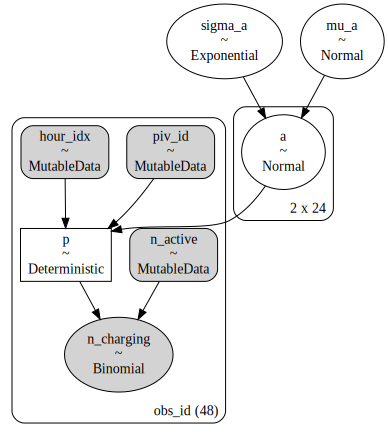

In [716]:
pm.model_to_graphviz(binomial_model)

array([[<Axes: title={'center': 'mu_a'}>,
        <Axes: title={'center': 'mu_a'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

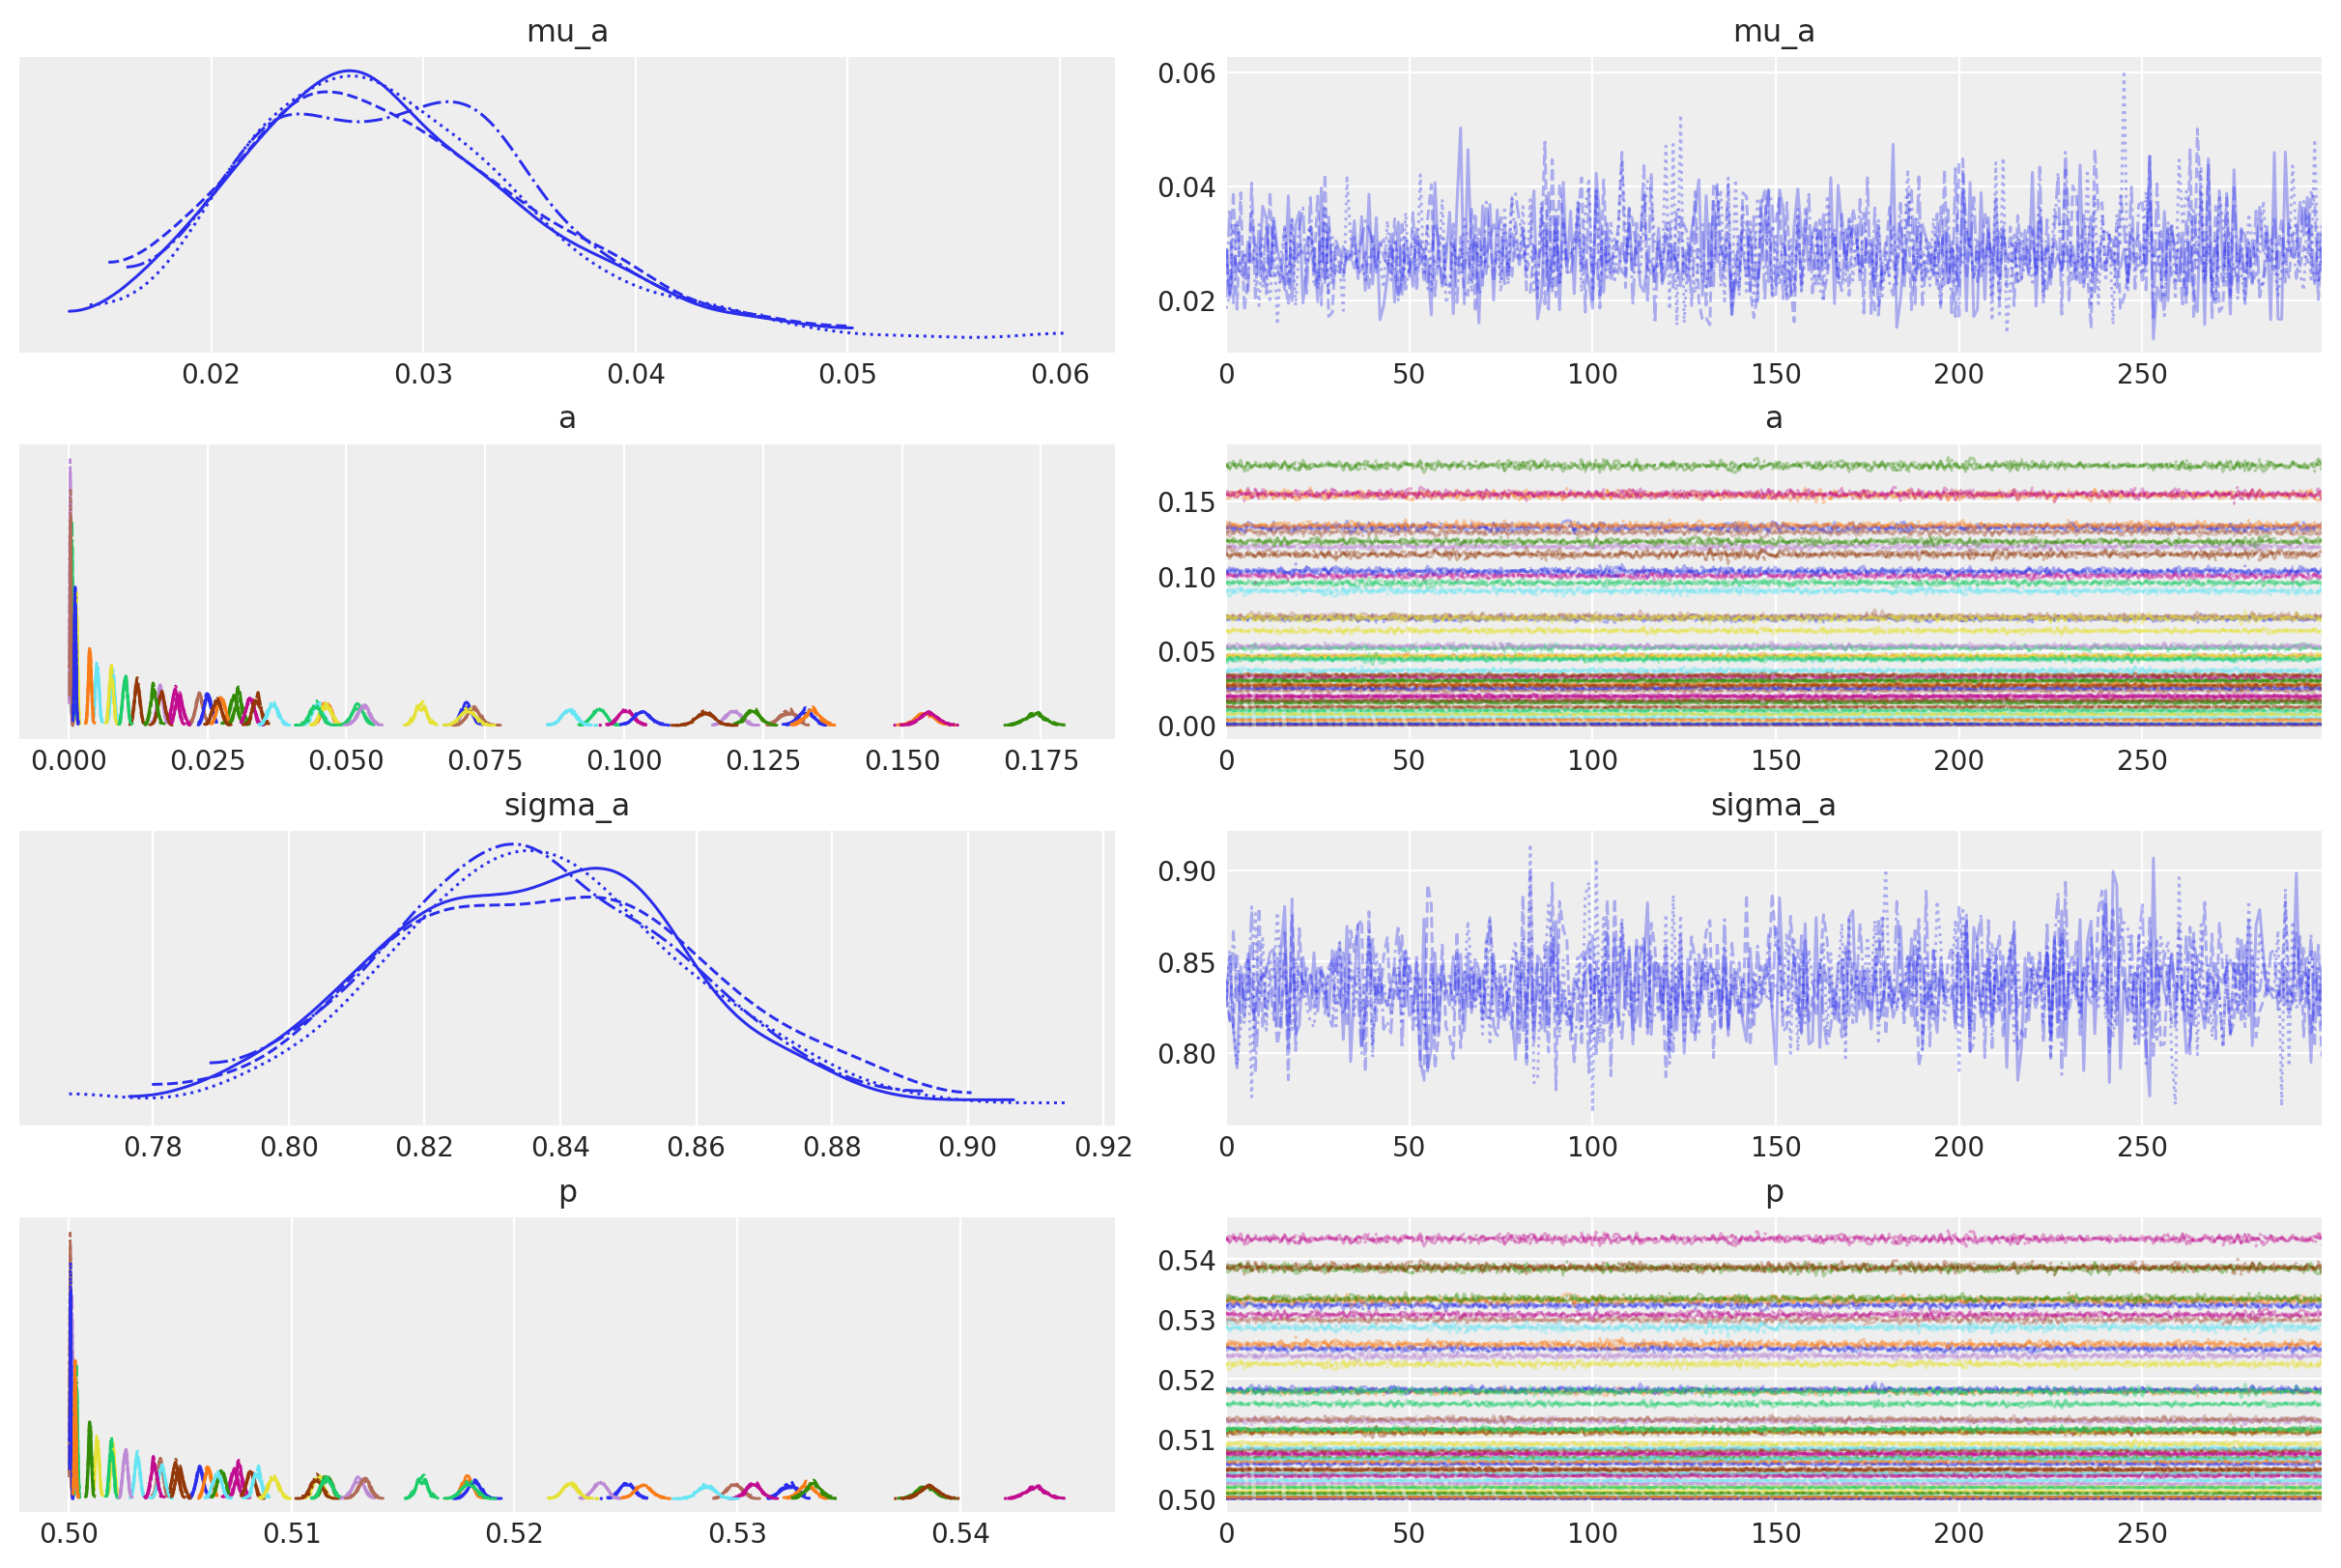

In [754]:
az.plot_trace(trace, transform=logistic)

### Functions for making predictions and plotting

In [762]:
def generate_24h_predictions(n, piv, trace):
    
    if piv == 'BEV':
        piv_id = 0
        charge_rate = 7
    elif piv == 'PHEV':
        piv_id = 1
        charge_rate = 3.7

    predictions = np.zeros([24, 4*draws])
    hour_indices = np.arange(24)

    for hour in hour_indices:
        with binomial_model:
            pm.set_data(
                {"hour_idx": [hour],
                 "n_active": [n],
                 "piv_id": [piv_id]
                }
            )
            new_trace = pm.sample_posterior_predictive(
                trace,
                var_names=['n_charging'],
                return_inferencedata=True,
                predictions=True,
                random_seed=RANDOM_SEED,
            )
        combined_trace = new_trace.stack(combined=('chain', 'draw'))
        predictions[hour] = combined_trace.predictions.n_charging[0].to_numpy()

    predictions *= charge_rate
    return predictions

def calculate_percentile_profile(percentile, predictions):
    profile = np.zeros(24)
    for i in np.arange(24):
        profile[i] = np.percentile(predictions[i], percentile)
    return profile

def plot_daily_profile(predictions, n, piv):
    
    fig, ax = plt.subplots(figsize=(12,6))

    ax.fill_between(x=range(24), 
                    y1=calculate_percentile_profile(25, predictions), 
                    y2=calculate_percentile_profile(75, predictions), 
                    color=colors[19],
                    alpha=0.4,
                    label='Interquartile Range')

    ax.fill_between(x=range(24), 
                    y1=calculate_percentile_profile(5, predictions), 
                    y2=calculate_percentile_profile(95, predictions), 
                    color=colors[19],
                    alpha=0.2,
                    label='5th to 95th Percentile')
    
    ax.fill_between(x=range(24), 
                    y1=calculate_percentile_profile(1, predictions), 
                    y2=calculate_percentile_profile(99, predictions), 
                    color=colors[19],
                    alpha=0.1,
                    label='1st to 99th Percentile')

    ax.plot(calculate_percentile_profile(50, predictions), 
            linewidth=2, 
            c='green', 
            label='Median')

    ax.plot(calculate_percentile_profile(0, predictions), 
            linewidth=1, 
            c=colors[1], 
            label='Minimum',
            linestyle='--')

    ax.plot(calculate_percentile_profile(100, predictions), 
            linewidth=1, 
            c=colors[19], 
            label='Maximum',
            linestyle='--')

    if piv == 'BEV':
        charge_rate = 7
    elif piv == 'PHEV':
        charge_rate = 3.7

    if piv == 'BEV' or piv == 'PHEV':
        ax.set_title('Total Charging Demand for {}s at Distribution Substation: {} in {} ({}kW Power)'.format(piv, DS_number, target_year, charge_rate))
    else:
        ax.set_title('Total Charging Demand for EVs (BEV & PHEV) at Distribution Substation: {} in {}'.format(DS_number, target_year))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), 
            reversed(labels), 
            bbox_to_anchor=(1, 0.9), 
            title='Percentile', 
            title_fontsize=16, 
            fontsize=10)

    ax.set_xticks(range(0,24))
    ax.set_ylabel('Demand (kW)', fontsize=16)
    ax.set_xlabel('Time (Hours)', fontsize=16)
    ax.set_xlim(0, 23)
    plt.show()

### Plotting the Probabilistic Demand Profiles

In [220]:
n = pred_num_bev_chargers
piv = "BEV"

predictions = generate_24h_predictions(n, piv, trace)
predictions

array([[28., 56., 28., ...,  7., 21., 42.],
       [14., 35., 21., ...,  0., 14., 28.],
       [ 7., 28., 14., ...,  0.,  7., 21.],
       ...,
       [49., 84., 56., ..., 21., 42., 63.],
       [49., 77., 49., ..., 21., 42., 63.],
       [35., 70., 42., ..., 14., 28., 56.]])

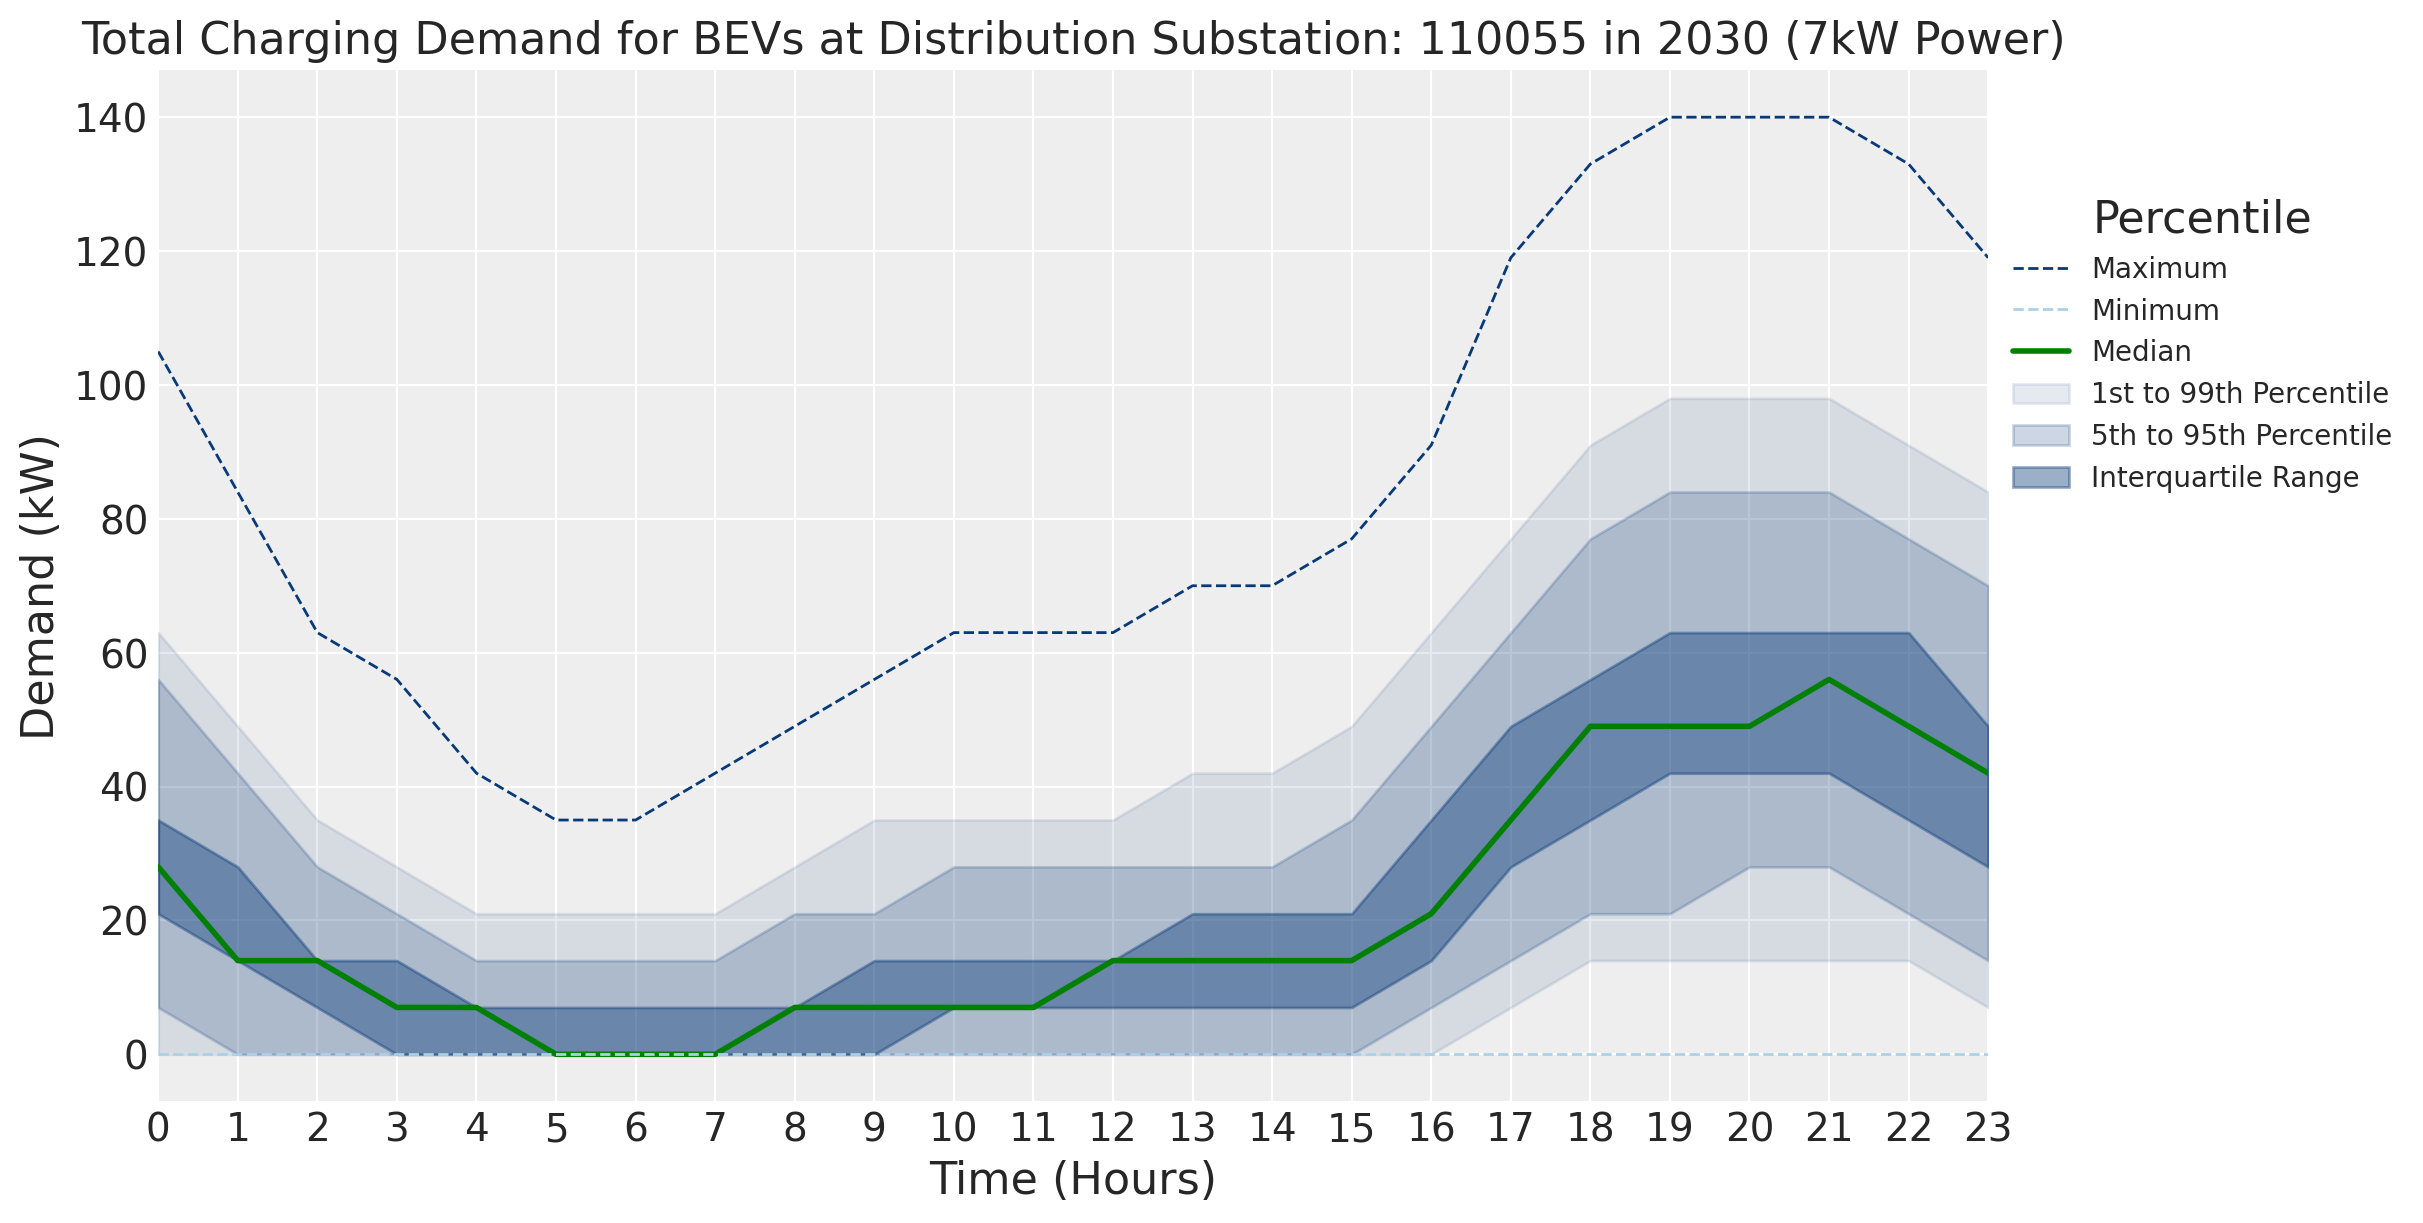

In [221]:
plot_daily_profile(predictions, n=n, piv=piv)

In [222]:
n = pred_num_phev_chargers
piv = "PHEV"

predictions = generate_24h_predictions(n, piv, trace)
predictions

array([[0. , 3.7, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 7.4, 3.7, ..., 0. , 0. , 3.7],
       [0. , 7.4, 0. , ..., 0. , 0. , 3.7],
       [0. , 3.7, 0. , ..., 0. , 0. , 3.7]])

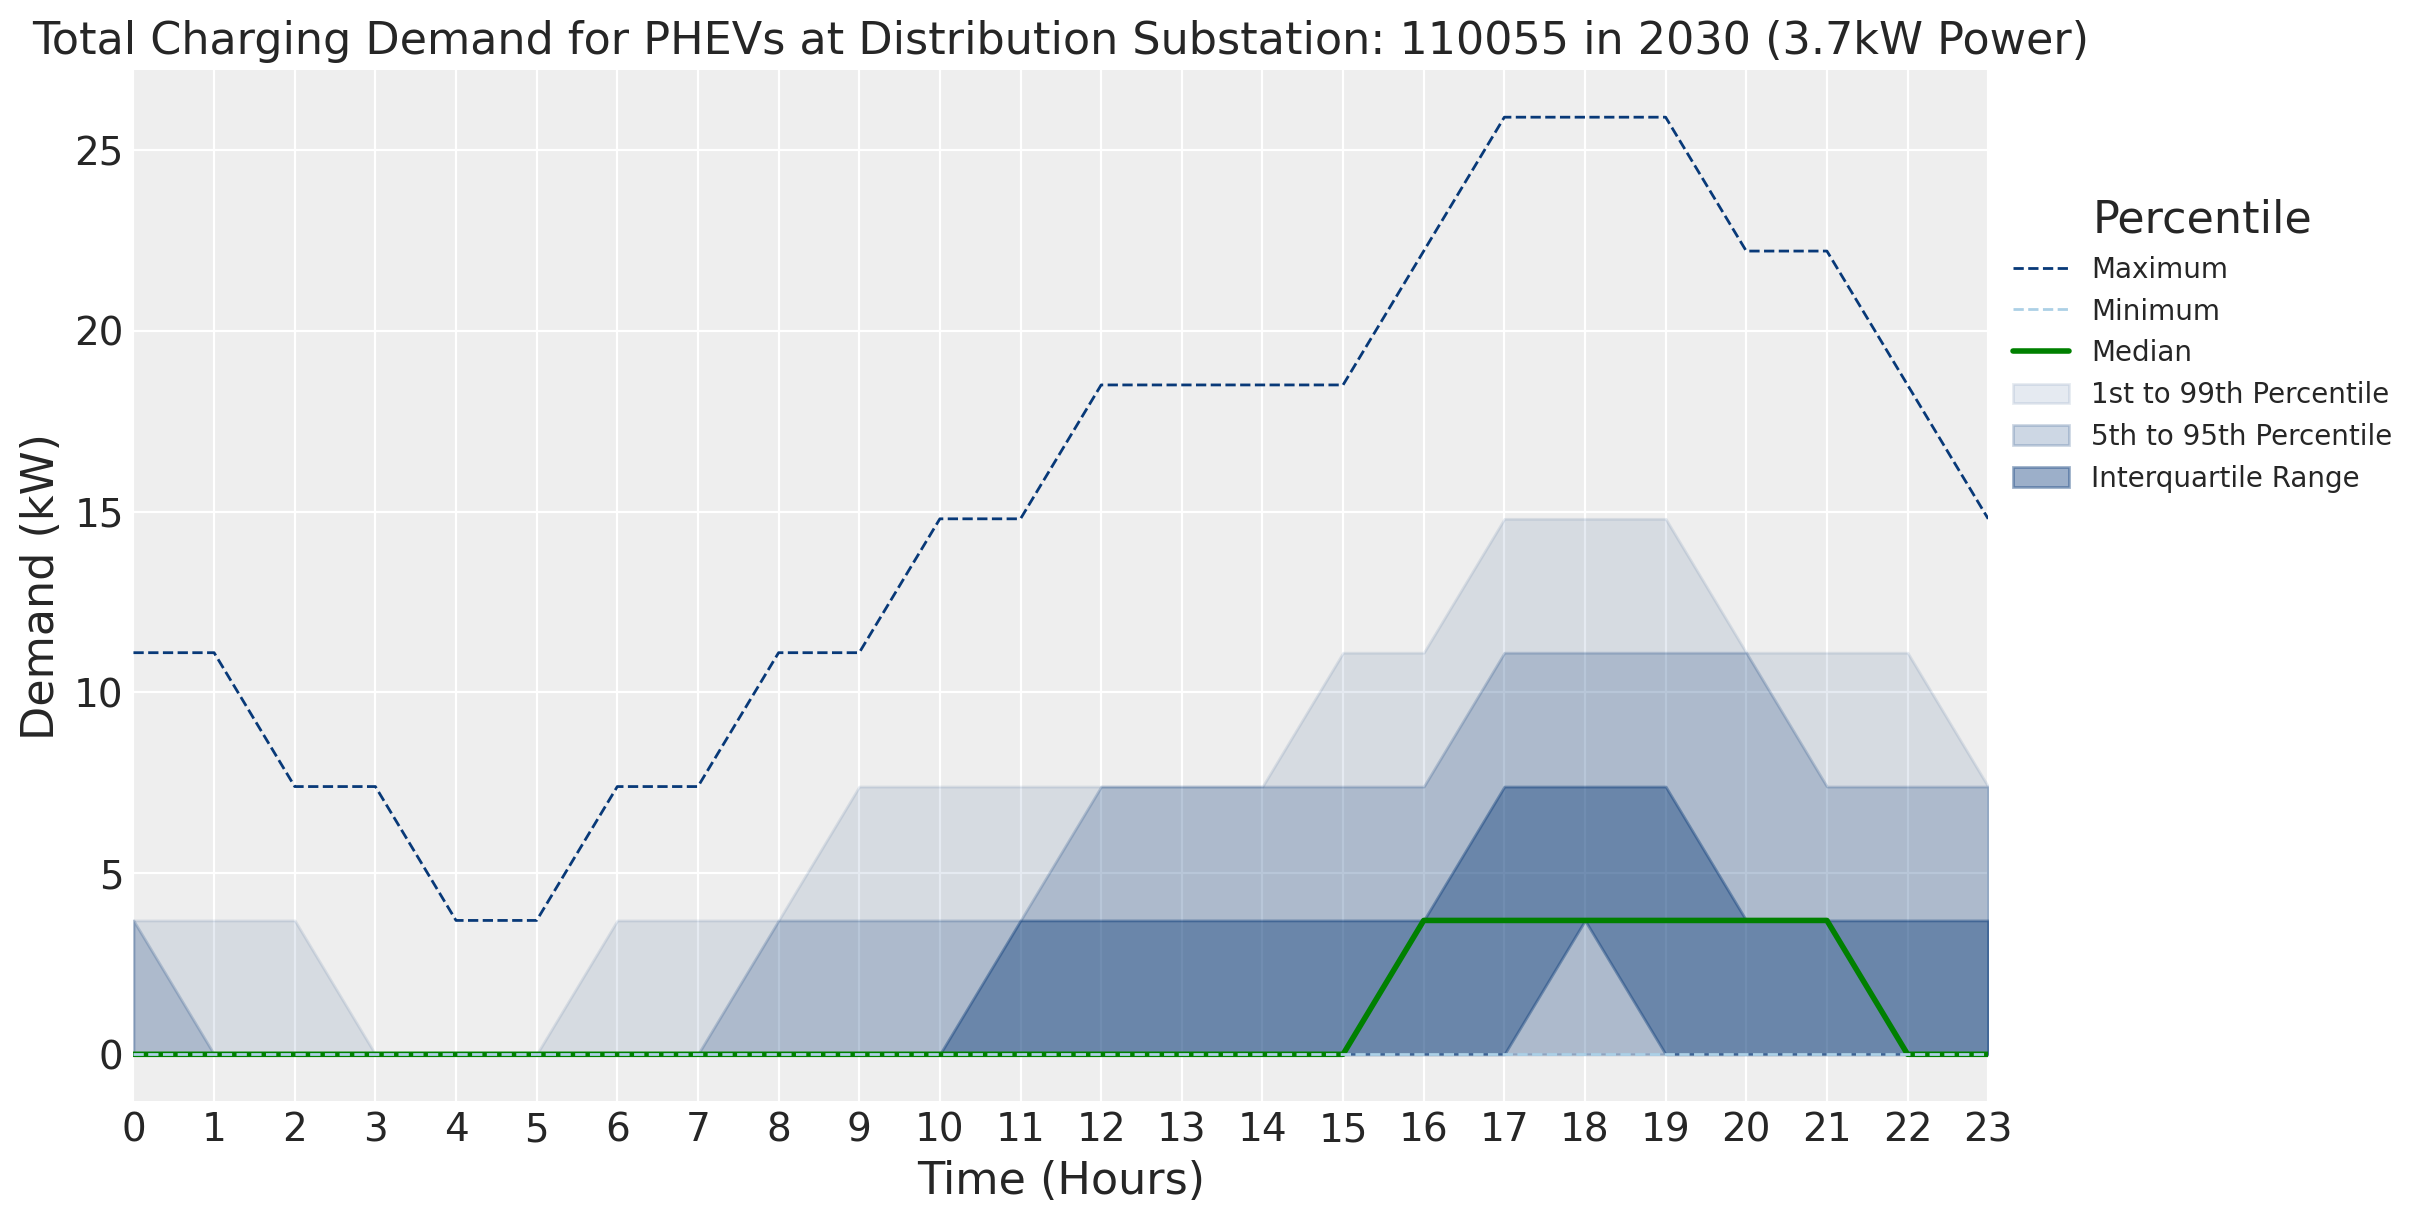

In [223]:
plot_daily_profile(predictions, n=n, piv=piv)

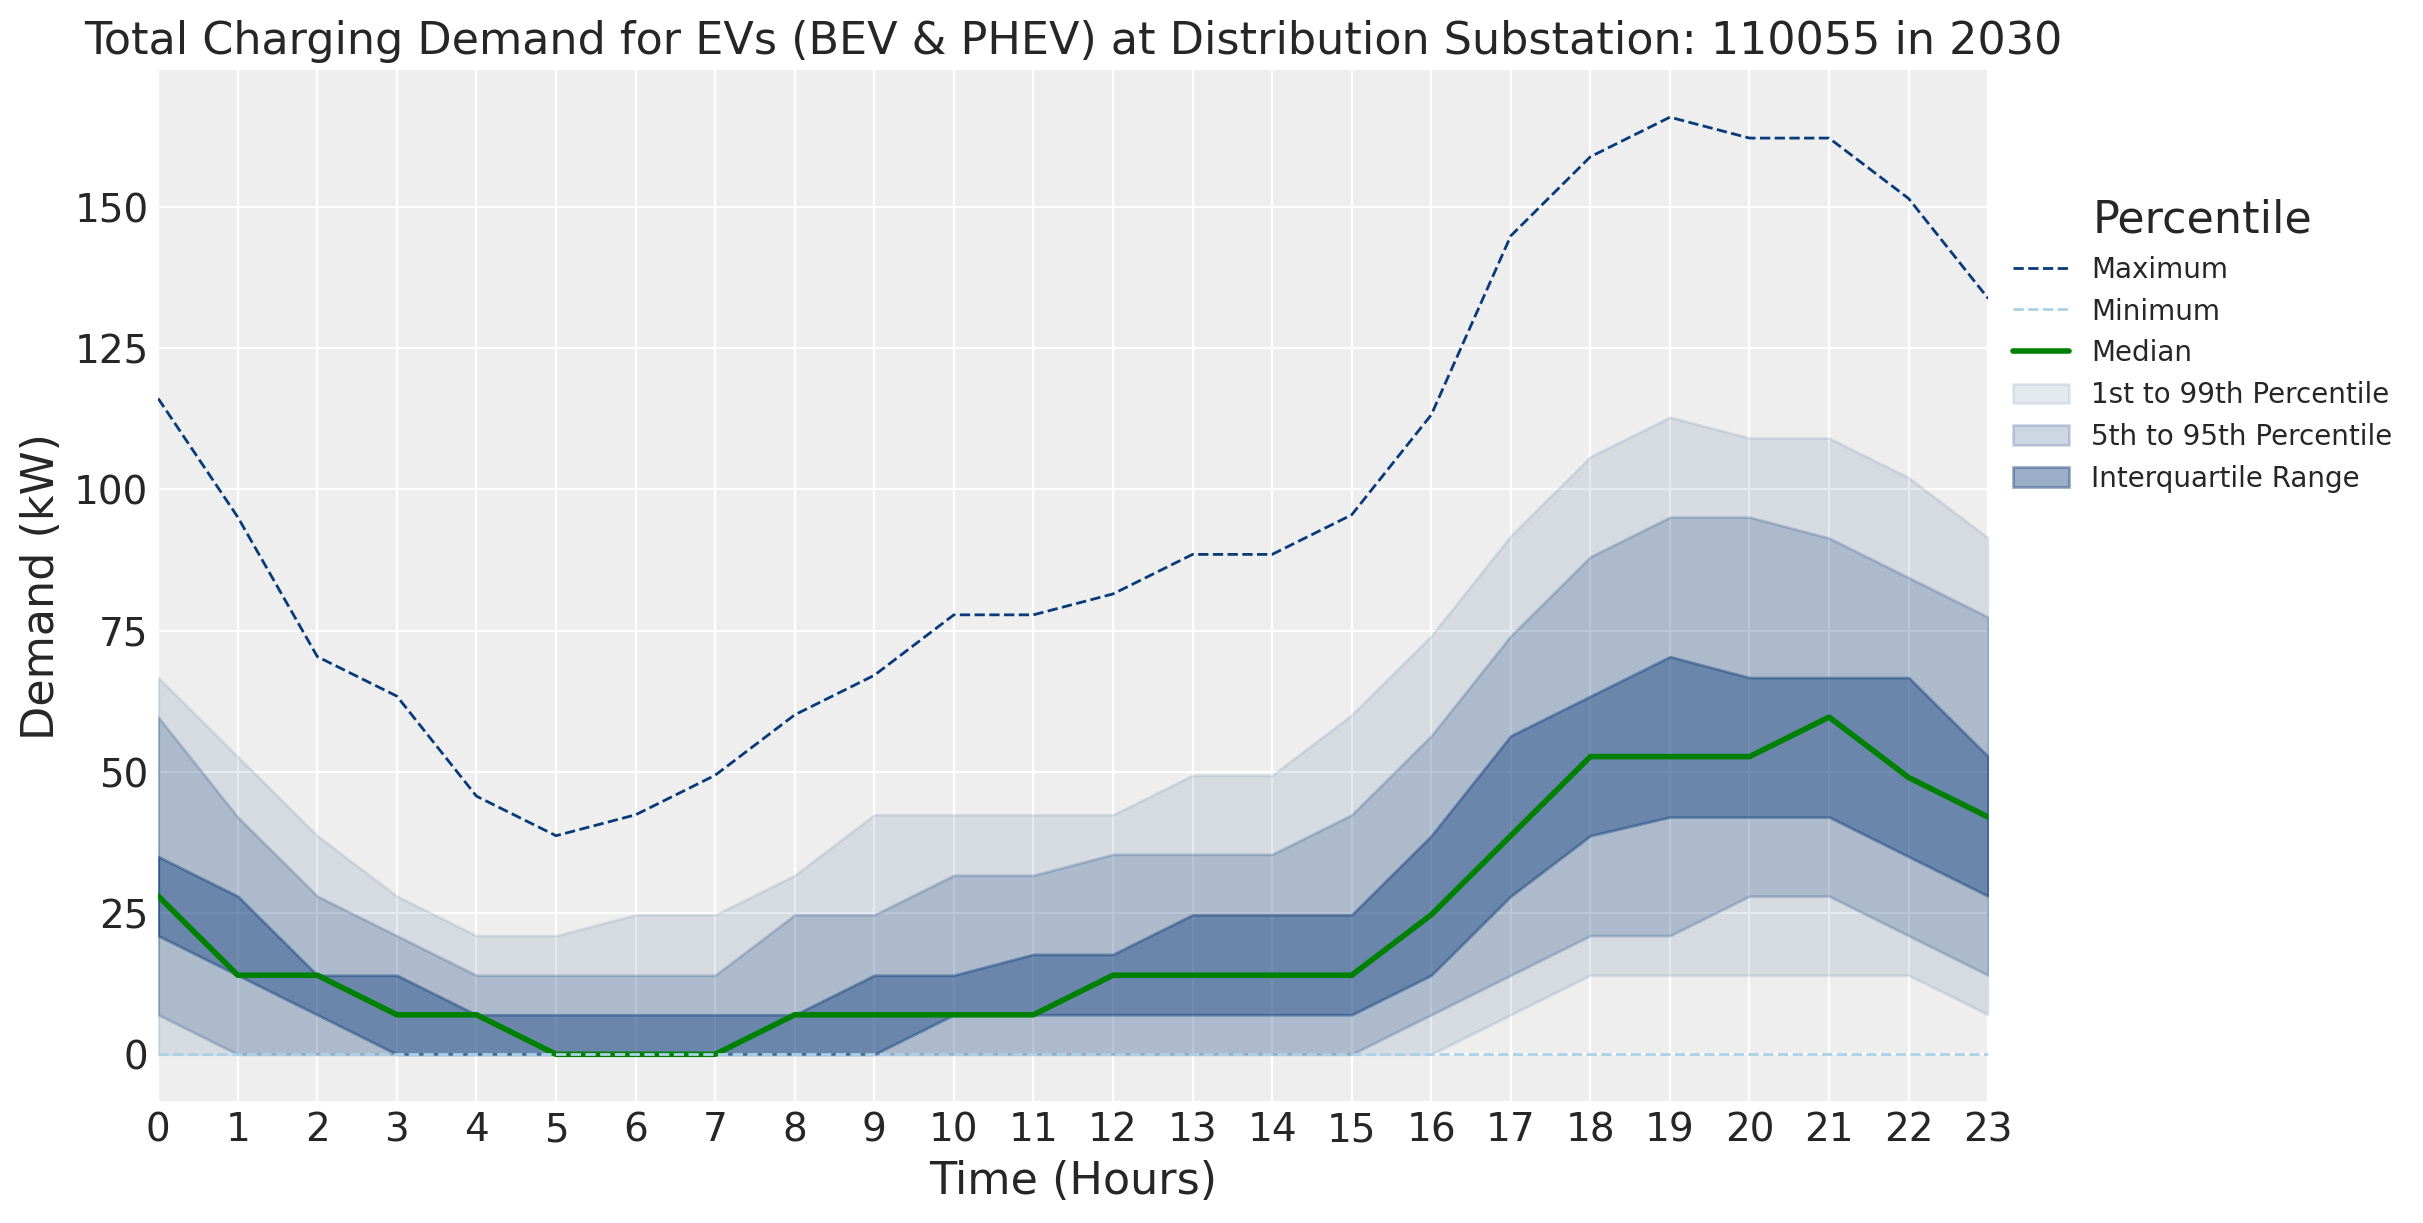

In [225]:
predictions = generate_24h_predictions(n=pred_num_bev_chargers, piv='BEV', trace=trace) + generate_24h_predictions(n=pred_num_phev_chargers, piv='PHEV', trace=trace)
plot_daily_profile(predictions, n='', piv='')

## Exceedance Probability

In [517]:
def calculate_exceedance_probabilities(predictions, substation_capacities):
    probabilities = []
    for i in range(len(substation_capacities)):
        # Calculate the exceedance probability
        prediction = predictions[i]
        capacity = substation_capacities[i]
        exceedance_prob = np.mean(prediction > capacity)
        probabilities.append(exceedance_prob)
    
    return probabilities

# Complete Model

### Inputs

In [278]:
ds_LA['Substation Number'].sample().values[0]

'162189'

In [678]:
target_year = 2040
DS_number = '110055'
horizon = 2050 # Forecast Horizon
bev_res_charger_access = 0.8 # assume 80% of BEVs have access to a residential charger
phev_res_charger_access = 0.6 # assume 60% of PHEVs have access to a residential charger
dates = calculate_date_range(calculate_t0(bev_pen_lsoa), horizon, sample_rate)

### LSOA-DS Mapping and n_vehicle estimation

In [679]:
parent_lsoa = lsoa_LA.loc[lsoa_LA.geometry.contains(ds_LA[ds_LA['Substation Number'] == DS_number].iloc[0].Location)].index[0]
n_customers = ds_LA[ds_LA['Substation Number'] == DS_number].fillna(0).iloc[0].Customers
n_vehicle_est = n_customers * vehicles_per_household.loc[parent_lsoa]

print(parent_lsoa)
print(n_customers)
print(n_vehicle_est)

E01014452
129.0
165.68986384266262


### Making EV Penetration Projections

In [680]:
bev_pen_proj = fit_generalised_logistic_curve(
    logistic_growth=generalised_logistic_growth, 
    data=bev_pen_lsoa[parent_lsoa], 
    t0=calculate_t0(bev_pen_lsoa[parent_lsoa]), 
    t_present=calculate_t_present(bev_pen_lsoa[parent_lsoa]), 
    horizon=horizon, 
    sample_rate=sample_rate, 
    p0=[0, 1, 5, -5]
)

phev_pen_proj = fit_generalised_logistic_curve(
    logistic_growth=generalised_logistic_growth, 
    data=phev_pen_lsoa[parent_lsoa], 
    t0=calculate_t0(phev_pen_lsoa[parent_lsoa]), 
    t_present=calculate_t_present(phev_pen_lsoa[parent_lsoa]), 
    horizon=horizon, 
    sample_rate=sample_rate, 
    p0=[0, 1, 5, -5]
)

/var/folders/3p/gfh9bx_x6g538359fqt4lgtm0000gn/T/ipykernel_84665/2894642042.py:6: RuntimeWarning: invalid value encountered in power
  denominator = (C + Q*np.exp(-B * (t - M)))**(1/v)


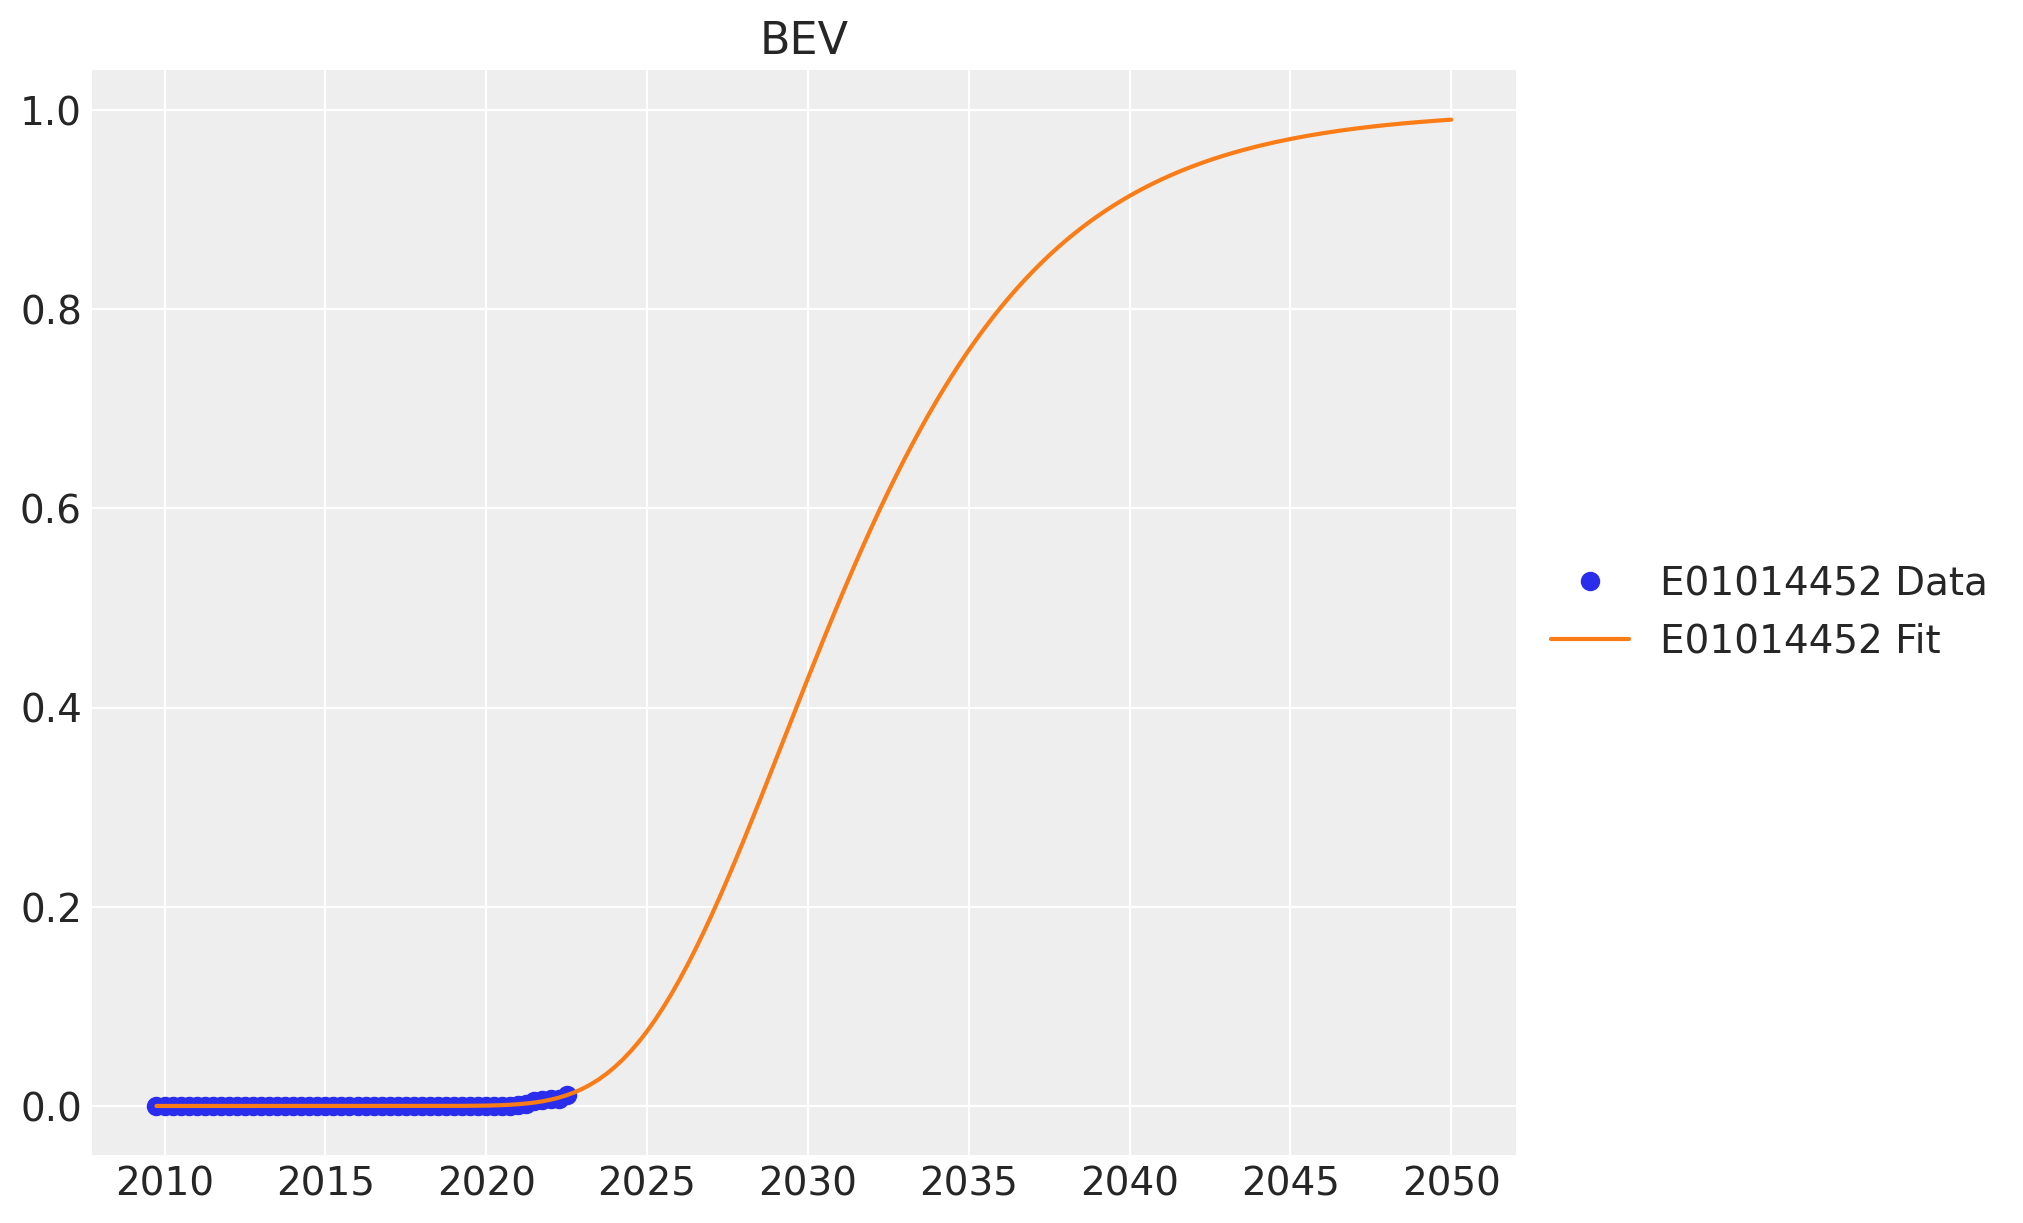

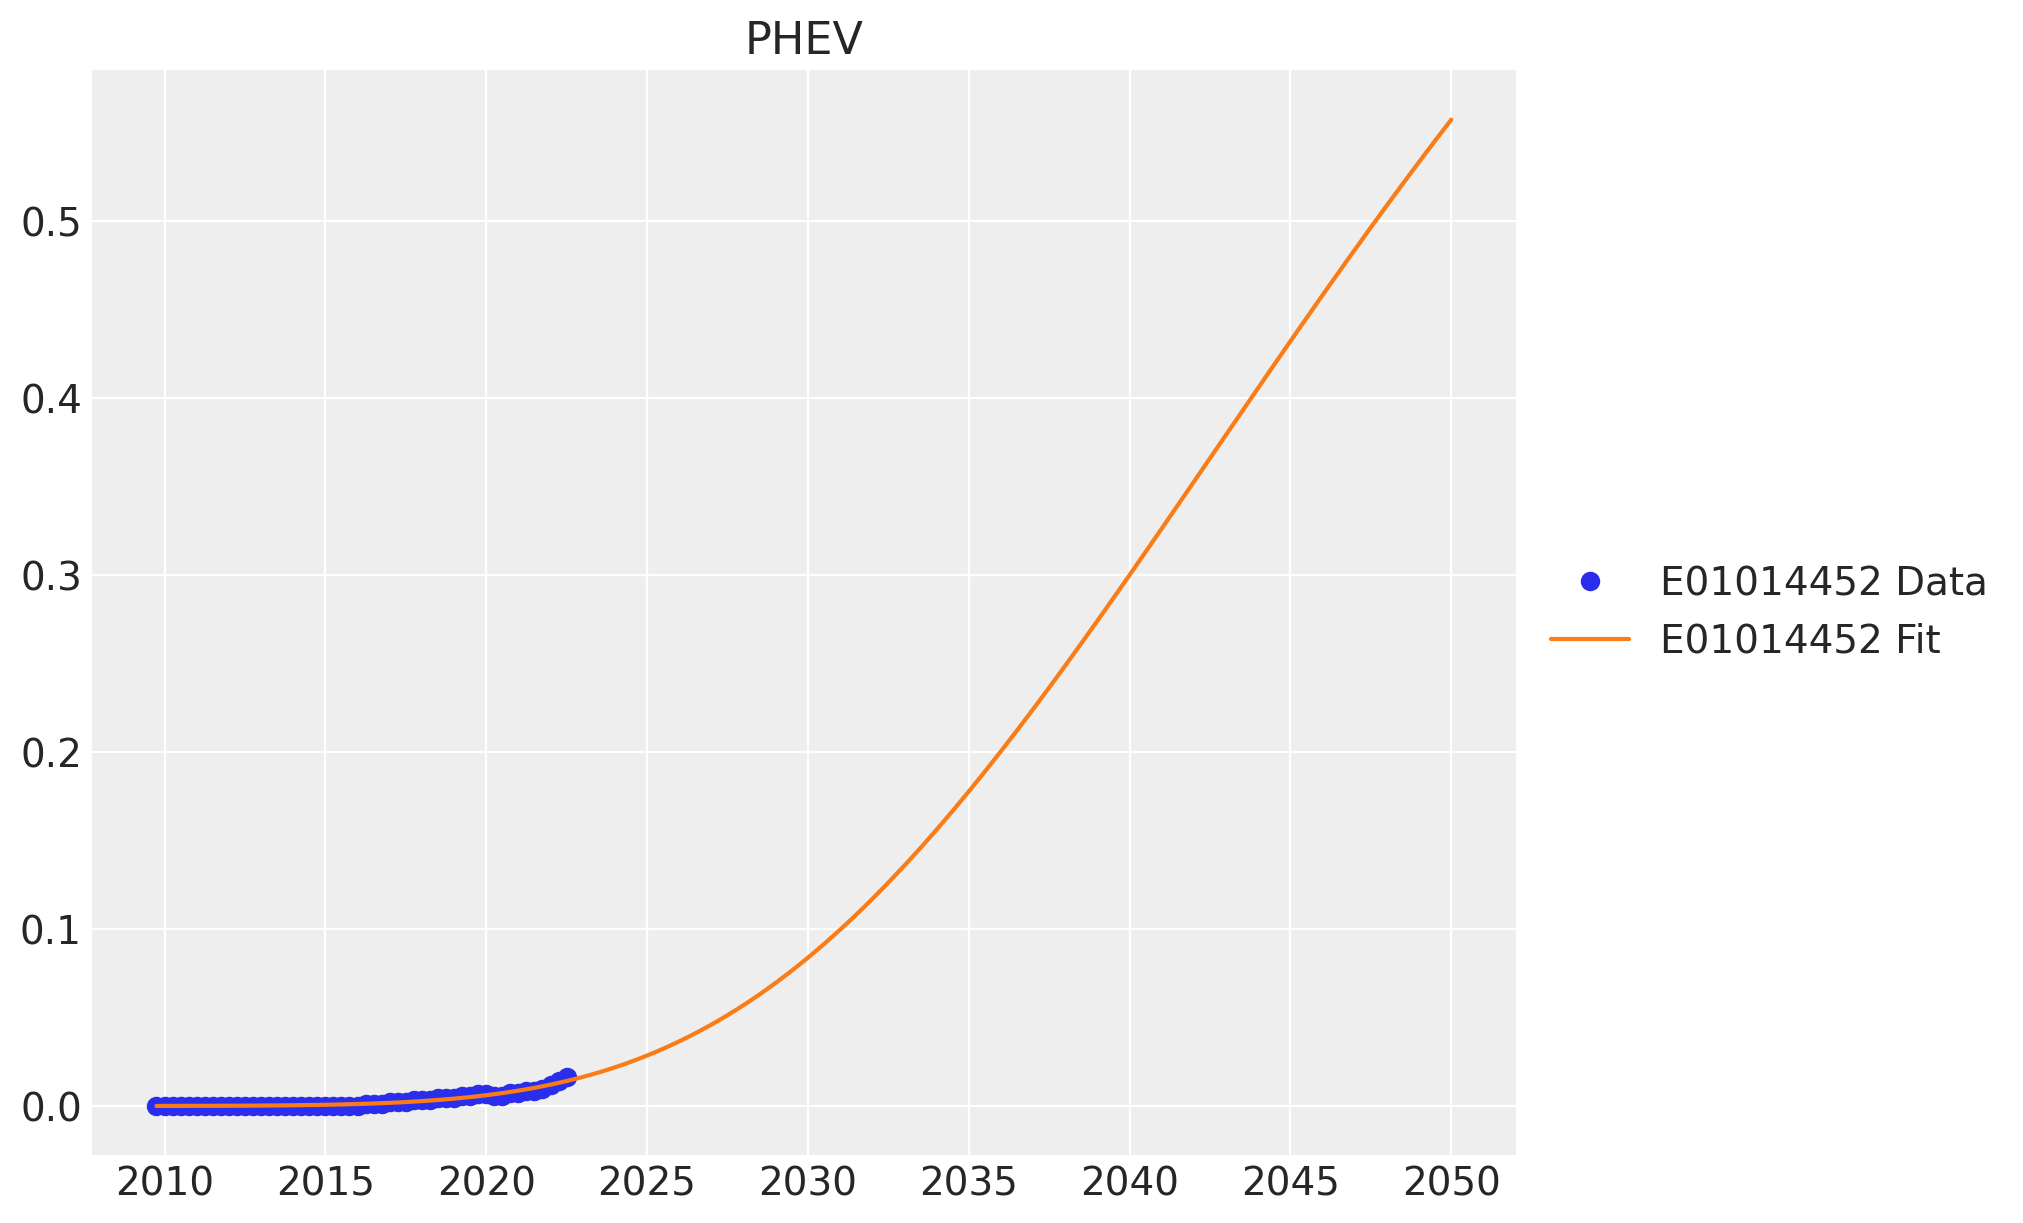

In [616]:
plot_generalised_logistic_projection(
    bev_pen_lsoa[parent_lsoa], 
    bev_pen_proj, 
    dates=dates, 
    t0=calculate_t0(bev_pen_lsoa), 
    t_present=calculate_t_present(bev_pen_lsoa), 
    sample_rate=sample_rate, 
    title='BEV', 
    region=parent_lsoa
)

plot_generalised_logistic_projection(
    phev_pen_lsoa[parent_lsoa], 
    phev_pen_proj, 
    dates=dates, 
    t0=calculate_t0(phev_pen_lsoa), 
    t_present=calculate_t_present(phev_pen_lsoa), 
    sample_rate=sample_rate, 
    title='PHEV', 
    region=parent_lsoa
)

In [681]:
bev_pen_proj_s = pd.Series(data=bev_pen_proj, index=dates) # Make into a series for easy indexing
phev_pen_proj_s = pd.Series(data=phev_pen_proj, index=dates)

pred_n_bev = round(n_vehicle_est * bev_pen_proj_s.loc[target_year])
pred_n_phev = round(n_vehicle_est * phev_pen_proj_s.loc[target_year])

print(pred_n_bev)
print(pred_n_phev)

151
50


### Estimate the number of EVs with access to residential charging

In [682]:
pred_num_bev_chargers = round(pred_n_bev * bev_res_charger_access)
pred_num_phev_chargers = round(pred_n_phev * phev_res_charger_access)

print(pred_num_bev_chargers)
print(pred_num_phev_chargers)

121
30


### Making probabilistic demand profile predictions

In [759]:
generate_24h_predictions(n=pred_num_bev_chargers, piv='BEV', trace=trace)

array([[ 56.,  98.,  63., ...,  49.,  56.,  49.],
       [ 35.,  63.,  42., ...,  28.,  35.,  28.],
       [ 21.,  49.,  28., ...,  14.,  21.,  21.],
       ...,
       [112., 161., 119., ...,  98., 112.,  98.],
       [ 98., 147., 105., ...,  91., 105.,  91.],
       [ 84., 126.,  84., ...,  70.,  77.,  70.]])

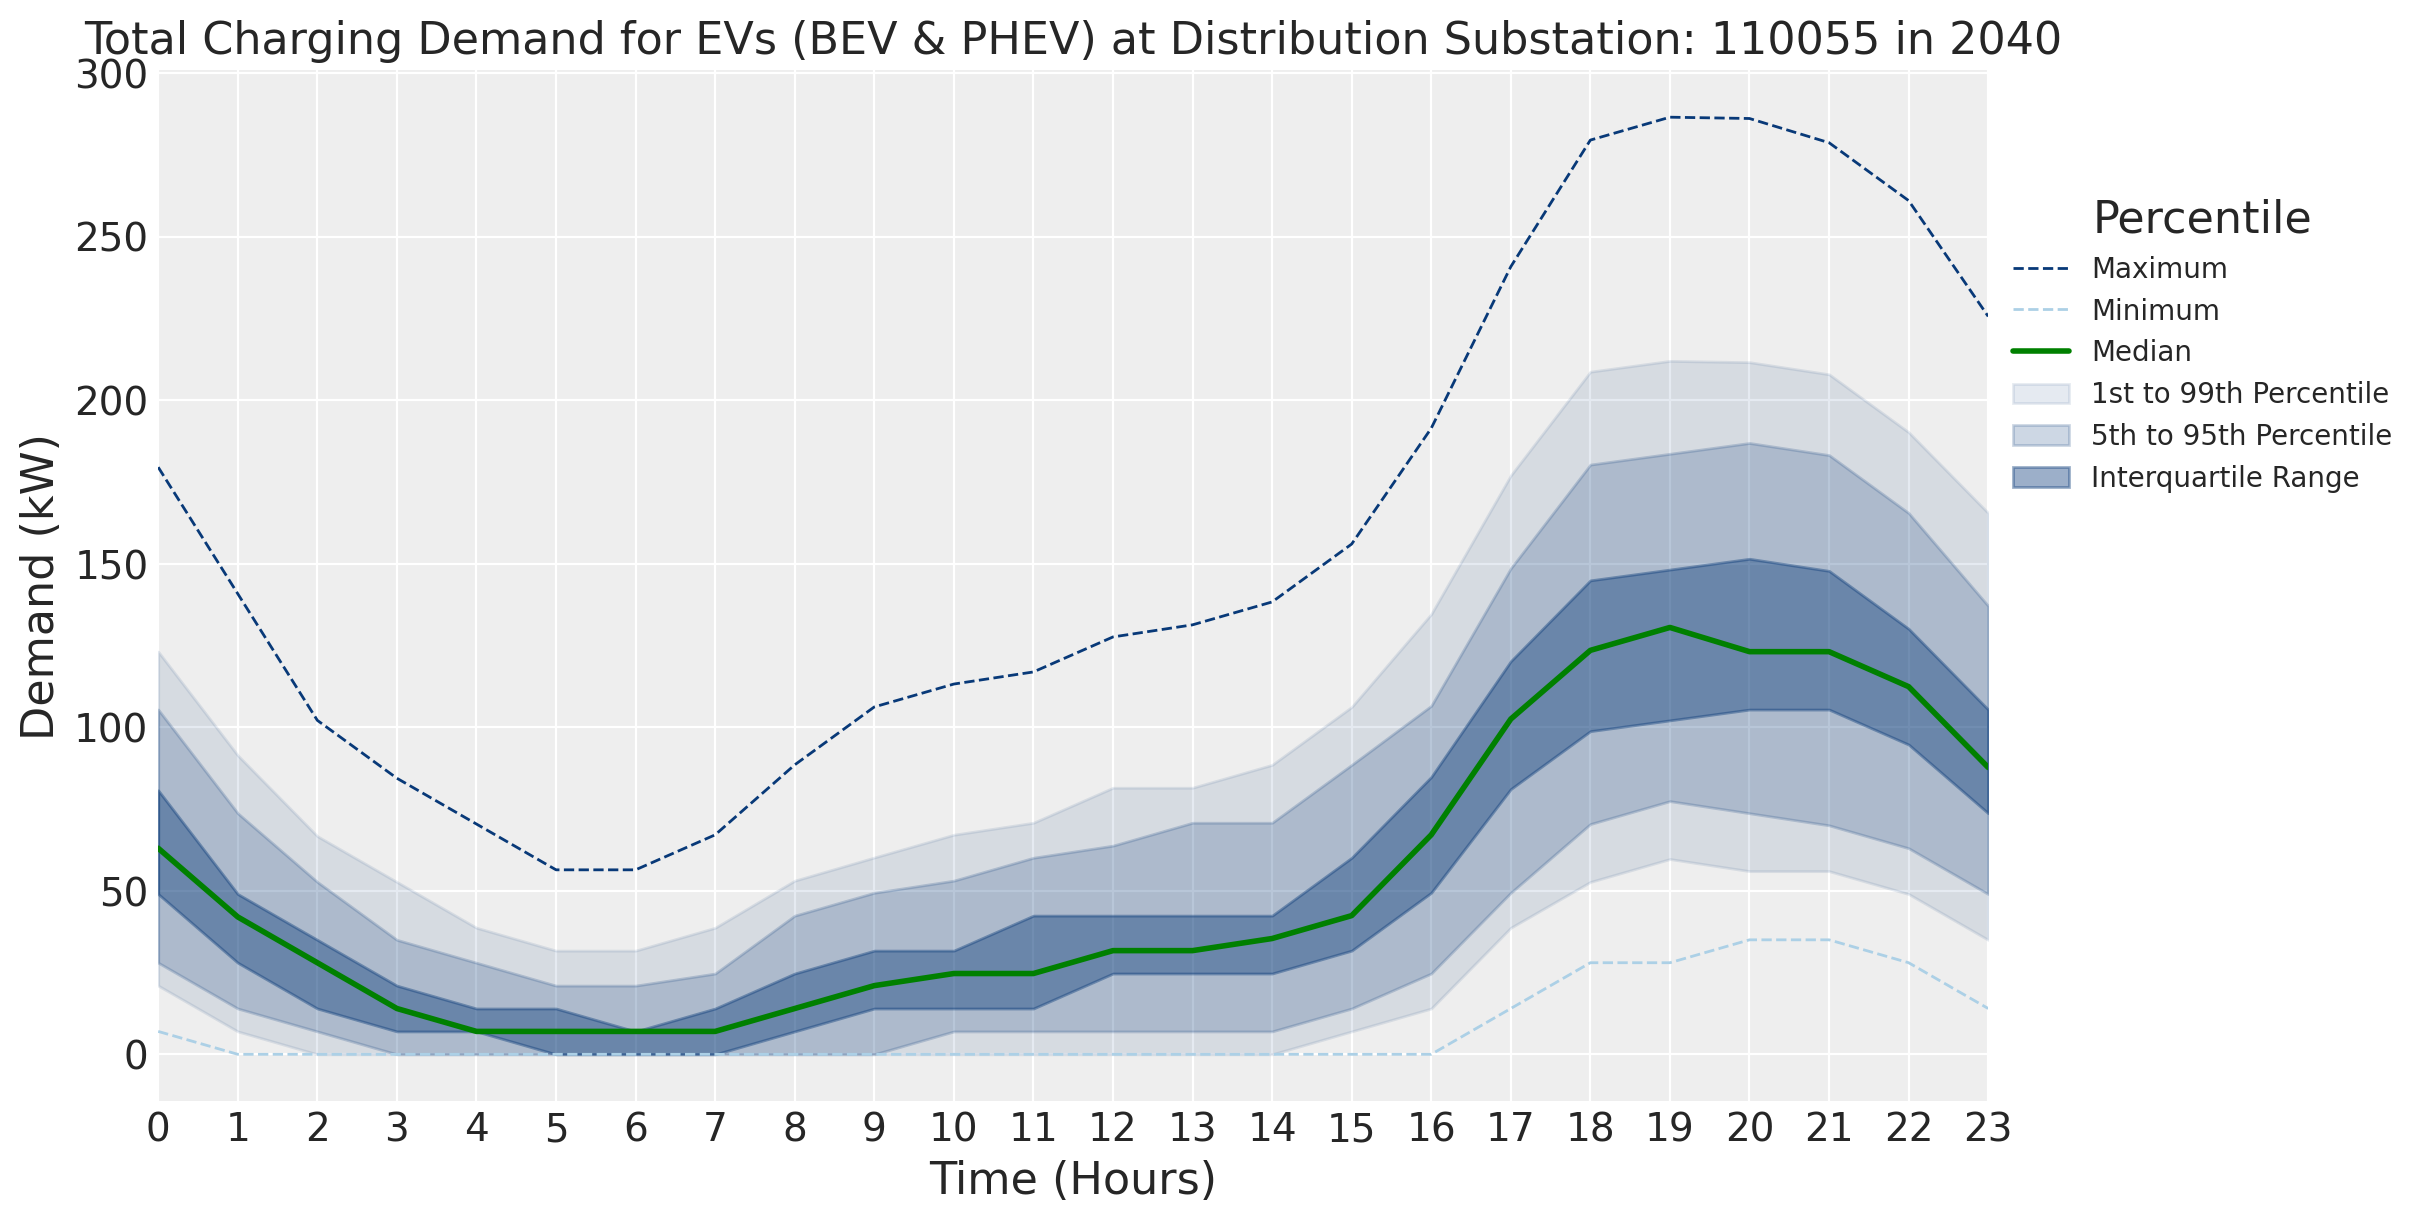

In [761]:
predictions = generate_24h_predictions(n=pred_num_bev_chargers, piv='BEV', trace=trace) + generate_24h_predictions(n=pred_num_phev_chargers, piv='PHEV', trace=trace)
plot_daily_profile(predictions, n='', piv='')

In [515]:
predictions

array([[28. , 59.7, 28. , ...,  7. , 21. , 42. ],
       [14. , 35. , 21. , ...,  0. , 14. , 28. ],
       [ 7. , 28. , 14. , ...,  0. ,  7. , 21. ],
       ...,
       [49. , 91.4, 59.7, ..., 21. , 42. , 66.7],
       [49. , 84.4, 49. , ..., 21. , 42. , 66.7],
       [35. , 73.7, 42. , ..., 14. , 28. , 59.7]])

# Exceedance Probabilities

## One Substation

In [519]:
ds_LA[ds_LA['Substation Number'] == DS_number]['Substation Rating'].values

array([500.])

In [522]:
(ds_LA[ds_LA['Substation Number'] == DS_number]['Substation Rating'].values) - (ds_LA[ds_LA['Substation Number'] == DS_number]['Day Max Demand'].values)

array([161.])

In [525]:
calculate_exceedance_probabilities(predictions, (ds_LA[ds_LA['Substation Number'] == DS_number]['Substation Rating'].values) - (ds_LA[ds_LA['Substation Number'] == DS_number]['Day Max Demand'].values))

[0.0]

## Multiple Substations

In [531]:
ds_LA['Spare_capacity'] = ds_LA['Substation Rating'] - ds_LA['Day Max Demand']
ds_LA['Spare_capacity']

/Users/isaacflower/miniconda3/envs/probabilistic_ev_demand_modelling/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


37      161.0
39      111.0
44      143.0
107     398.0
123     211.0
        ...  
8461      8.0
8476     49.0
8480    201.0
8522     98.0
8527     21.0
Name: Spare_capacity, Length: 1761, dtype: float64

In [526]:
ds_LA.PRIM_NRID_NAME.value_counts()

High Littleton                200
Batheaston                    172
Whitchurch                    153
Entry Hill                    120
Keynsham East                 116
Dorchester St - New           113
Midsomer Norton               108
Peasedown                     102
Compton Martin 33/11kv S/S    100
Combe Park                     82
Chew Stoke                     81
Chewton Mendip                 79
Foxhills                       72
Twerton                        59
Oldfield Park                  52
Paulton                        49
Keynsham West                  47
Park Street                    42
Blagdon 33/11kv S/S            11
Newbury                         3
Name: PRIM_NRID_NAME, dtype: int64

In [609]:
ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street'].head()

Substation Number                                           geometry  \
3329            160003  MULTIPOLYGON (((-2.36149 51.38437, -2.36149 51...   
3352            160027  POLYGON ((-2.37426 51.40346, -2.37442 51.40349...   
3355            160033  POLYGON ((-2.36778 51.37980, -2.36838 51.37960...   
3359            160037  POLYGON ((-2.36301 51.38734, -2.36302 51.38738...   
3380            160064  MULTIPOLYGON (((-2.36453 51.39216, -2.36444 51...   

       NRID  NR_TYPE_ID                NAME  PRIM_NRID PRIM_NRID_NAME  \
3329  39256          19     Bartlett Street      15062    Park Street   
3352  39302          19  Admiralty Ensleigh      15062    Park Street   
3355  39314          19          Green Park      15062    Park Street   
3359  39322          19           Hedgemead      15062    Park Street   
3380  39367          19       Richmond Hill      15062    Park Street   

      BSP_NRID         BSP_NRID_NAME  GSP_NRID  ...                Name  \
3329        94  Bath (Dolemeads) 132       131  ...     Bartlett Street   
3352        94  Bath (Dolemeads) 132       131  ...  Admiralty Ensleigh   
3355        94  Bath (Dolemeads) 132       131  ...          Green Park   
3359        94  Bath (Dolemeads) 132       131  ...           Hedgemead   
3380        94  Bath (Dolemeads) 132       131  ...       Richmond Hill   

      Grid Reference LONGITUDE  LATITUDE Day Max Demand  Night Max Demand  \
3329  ST749200652100   -2.3618   51.3853           19.0              22.0   
3352  ST741010674480   -2.3737   51.4054          169.0             142.0   
3355  ST745660648090   -2.3669   51.3817            0.0               0.0   
3359  ST749400656090   -2.3616   51.3889          678.0             513.0   
3380  ST748420661750   -2.3630   51.3940          217.0             107.0   

     Substation Rating Customers                   Location Spare_capacity  
3329            1000.0     161.0  POINT (-2.36180 51.38530)          981.0  
3352             500.0      91.0  POINT (-2.37370 51.40540)          331.0  
3355            1000.0     374.0  POINT (-2.36690 51.38170)         1000.0  
3359            1000.0     511.0  POINT (-2.36160 51.38890)          322.0  
3380             300.0     115.0  POINT (-2.36300 51.39400)           83.0  

[5 rows x 31 columns]

In [593]:
ds_numbers = ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street']['Substation Number'].values
ds_numbers

array(['160003', '160027', '160033', '160037', '160064', '160067',
       '160072', '160083', '160091', '160097', '160103', '160105',
       '160198', '160201', '160231', '160245', '160246', '160249',
       '160264', '160268', '160273', '160274', '160283', '160287',
       '160315', '160320', '160346', '160356', '160371', '160378',
       '160380', '160391', '162082', '164060', '164067', '164071',
       '164092', '164107', '164109', '164110', '164113', '164154'],
      dtype=object)

### Packaging up all the functions

In [663]:
def make_demand_profile_predictions(ds_numbers, horizon, year):
    all_predictions = []
    for ds_number in ds_numbers:
        parent_lsoa = lsoa_LA.loc[lsoa_LA.geometry.contains(ds_LA[ds_LA['Substation Number'] == ds_number].iloc[0].Location)].index[0]
        n_customers = ds_LA[ds_LA['Substation Number'] == ds_number].fillna(0).iloc[0].Customers
        n_vehicle_est = n_customers * vehicles_per_household.loc[parent_lsoa]

        bev_pen_proj = fit_generalised_logistic_curve(
            logistic_growth=generalised_logistic_growth, 
            data=bev_pen_lsoa[parent_lsoa], 
            t0=calculate_t0(bev_pen_lsoa[parent_lsoa]), 
            t_present=calculate_t_present(bev_pen_lsoa[parent_lsoa]), 
            horizon=horizon, 
            sample_rate=sample_rate, 
            p0=[0, 1, 5, -5]
        )

        phev_pen_proj = fit_generalised_logistic_curve(
            logistic_growth=generalised_logistic_growth, 
            data=phev_pen_lsoa[parent_lsoa], 
            t0=calculate_t0(phev_pen_lsoa[parent_lsoa]), 
            t_present=calculate_t_present(phev_pen_lsoa[parent_lsoa]), 
            horizon=horizon, 
            sample_rate=sample_rate, 
            p0=[0, 1, 5, -5]
        )

        bev_pen_proj_s = pd.Series(data=bev_pen_proj, index=dates) # Make into a series for easy indexing
        phev_pen_proj_s = pd.Series(data=phev_pen_proj, index=dates)

        pred_n_bev = round(n_vehicle_est * bev_pen_proj_s.loc[year])
        pred_n_phev = round(n_vehicle_est * phev_pen_proj_s.loc[year])

        pred_num_bev_chargers = round(pred_n_bev * bev_res_charger_access)
        pred_num_phev_chargers = round(pred_n_phev * phev_res_charger_access)

        predictions = generate_24h_predictions(n=pred_num_bev_chargers, piv='BEV', trace=trace) + generate_24h_predictions(n=pred_num_phev_chargers, piv='PHEV', trace=trace)

        all_predictions.append(predictions)
    return all_predictions

In [664]:
all_predictions = make_demand_profile_predictions(ds_numbers, horizon=2050, year=2040)
all_predictions

Sampling: [n_charging]


[array([[ 7. , 24.7,  7. , ...,  0. ,  0. , 14. ],
        [ 0. , 17.7,  7. , ...,  0. ,  0. ,  7. ],
        [ 0. , 14. ,  0. , ...,  0. ,  0. ,  7. ],
        ...,
        [17.7, 39.1, 17.7, ...,  0. , 10.7, 28.4],
        [10.7, 39.1, 17.7, ...,  0. ,  7. , 28.4],
        [ 7. , 28.4, 10.7, ...,  0. ,  7. , 17.7]]),
 array([[ 38.7,  81.1,  45.7, ...,  14. ,  31.7,  56.4],
        [ 21. ,  56.4,  28. , ...,   7. ,  21. ,  38.7],
        [ 14. ,  38.7,  14. , ...,   0. ,  14. ,  21. ],
        ...,
        [ 92.2, 152.7, 102.9, ...,  53.1,  85.2, 124.3],
        [ 81.5, 138.3,  92.2, ...,  42.4,  70.8, 109.9],
        [ 67.1, 113.2,  67.1, ...,  31.7,  49.4,  88.5]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[179.1, 249.9, 189.8, ..., 115.7, 154.4, 207.5],
        [108.7, 

In [665]:
all_predictions

[array([[ 7. , 24.7,  7. , ...,  0. ,  0. , 14. ],
        [ 0. , 17.7,  7. , ...,  0. ,  0. ,  7. ],
        [ 0. , 14. ,  0. , ...,  0. ,  0. ,  7. ],
        ...,
        [17.7, 39.1, 17.7, ...,  0. , 10.7, 28.4],
        [10.7, 39.1, 17.7, ...,  0. ,  7. , 28.4],
        [ 7. , 28.4, 10.7, ...,  0. ,  7. , 17.7]]),
 array([[ 38.7,  81.1,  45.7, ...,  14. ,  31.7,  56.4],
        [ 21. ,  56.4,  28. , ...,   7. ,  21. ,  38.7],
        [ 14. ,  38.7,  14. , ...,   0. ,  14. ,  21. ],
        ...,
        [ 92.2, 152.7, 102.9, ...,  53.1,  85.2, 124.3],
        [ 81.5, 138.3,  92.2, ...,  42.4,  70.8, 109.9],
        [ 67.1, 113.2,  67.1, ...,  31.7,  49.4,  88.5]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[179.1, 249.9, 189.8, ..., 115.7, 154.4, 207.5],
        [108.7, 

In [666]:
ds_numbers

array(['160003', '160027', '160033', '160037', '160064', '160067',
       '160072', '160083', '160091', '160097', '160103', '160105',
       '160198', '160201', '160231', '160245', '160246', '160249',
       '160264', '160268', '160273', '160274', '160283', '160287',
       '160315', '160320', '160346', '160356', '160371', '160378',
       '160380', '160391', '162082', '164060', '164067', '164071',
       '164092', '164107', '164109', '164110', '164113', '164154'],
      dtype=object)

In [667]:
ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street']['Spare_capacity'].values

array([ 981.,  331., 1000.,  322.,   83.,  386.,  478.,  815.,   73.,
        128.,  148.,  267.,  706.,  407.,  370.,  304.,  159.,  216.,
        359.,  204.,  217.,  599.,  -44.,  218.,  559.,  417.,   74.,
        409.,  348.,  340.,  399.,  380.,   16.,  377.,  144.,  458.,
        477.,  734.,  593.,  266.,  359.,  800.])

In [668]:
ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street']['Spare_capacity'].values

array([ 981.,  331., 1000.,  322.,   83.,  386.,  478.,  815.,   73.,
        128.,  148.,  267.,  706.,  407.,  370.,  304.,  159.,  216.,
        359.,  204.,  217.,  599.,  -44.,  218.,  559.,  417.,   74.,
        409.,  348.,  340.,  399.,  380.,   16.,  377.,  144.,  458.,
        477.,  734.,  593.,  266.,  359.,  800.])

In [669]:
calculate_exceedance_probabilities(all_predictions, ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street']['Spare_capacity'].values)

[0.0,
 0.0,
 0.0,
 0.22414583333333332,
 0.14545833333333333,
 0.0,
 0.0,
 0.0,
 0.44946875,
 0.04421875,
 0.0,
 0.0007291666666666667,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00010416666666666667,
 0.00011458333333333333,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05529166666666667,
 0.0,
 5.208333333333334e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [670]:
exceedance_probabilities = pd.Series(data=calculate_exceedance_probabilities(all_predictions, ds_LA[ds_LA.PRIM_NRID_NAME == 'Park Street']['Spare_capacity'].values),
                                    index = ds_numbers
)

exceedance_probabilities

160003    0.000000
160027    0.000000
160033    0.000000
160037    0.224146
160064    0.145458
160067    0.000000
160072    0.000000
160083    0.000000
160091    0.449469
160097    0.044219
160103    0.000000
160105    0.000729
160198    0.000000
160201    0.000000
160231    0.000000
160245    0.000000
160246    0.000000
160249    0.000000
160264    0.000000
160268    0.000104
160273    0.000115
160274    0.000000
160283    1.000000
160287    0.000000
160315    0.000000
160320    0.000000
160346    0.000000
160356    0.000000
160371    0.000000
160378    0.000000
160380    0.000000
160391    0.000000
162082    0.055292
164060    0.000000
164067    0.000052
164071    0.000000
164092    0.000000
164107    0.000000
164109    0.000000
164110    0.000000
164113    0.000000
164154    0.000000
dtype: float64

In [671]:
exceedance_probabilities.sort_values(ascending=False)

160283    1.000000
160091    0.449469
160037    0.224146
160064    0.145458
162082    0.055292
160097    0.044219
160105    0.000729
160273    0.000115
160268    0.000104
164067    0.000052
160003    0.000000
160391    0.000000
160356    0.000000
160371    0.000000
160378    0.000000
160380    0.000000
164071    0.000000
164060    0.000000
160320    0.000000
164092    0.000000
164107    0.000000
164109    0.000000
164110    0.000000
164113    0.000000
160346    0.000000
160274    0.000000
160315    0.000000
160287    0.000000
160027    0.000000
160264    0.000000
160249    0.000000
160246    0.000000
160245    0.000000
160231    0.000000
160201    0.000000
160198    0.000000
160103    0.000000
160083    0.000000
160072    0.000000
160067    0.000000
160033    0.000000
164154    0.000000
dtype: float64